In [ ]:
import os
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix, classification_report


import warnings
# ignore all warnings
warnings.filterwarnings("ignore")

In [ ]:
final_columns = {
    'ACC': ['id', 'X', 'Y', 'Z', 'datetime'],
    'BVP': ['id', 'BVP', 'datetime'],
    'EDA': ['id', 'EDA', 'datetime'],
    'HR': ['id', 'HR', 'datetime'],
    'TEMP': ['id', 'TEMP', 'datetime'],
}

names = {                                                                                                                                                                                                                                                              
    'ACC': ['X', 'Y', 'Z'],
    'BVP': ['BVP'],
    'EDA': ['EDA'],
    'HR': ['HR'],
    'TEMP': ['TEMP'],
    'tags':['tags']
}

desired_signals = ['ACC', 'BVP','EDA', 'HR', 'TEMP']


In [ ]:
def process_df(df, file):
    start_timestamp = df.iloc[0, 0]
    sample_rate = df.iloc[1, 0]
    new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
    new_df['id'] = file
    new_df['datetime'] = [(start_timestamp + i / sample_rate) for i in range(len(new_df))]

    return new_df

In [ ]:
data = {}
for file in range(2,36):       
    
    if file > 9:
       data_path_acc = "https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S" + str(file) + "/" + "ACC.csv"
       data_path_bvp = "https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S" + str(file) + "/" + "BVP.csv"
       data_path_eda = "https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S" + str(file) + "/" + "EDA.csv"
       data_path_hr = "https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S" + str(file) + "/" + "HR.csv"
       data_path_temp = "https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S" + str(file) + "/" + "TEMP.csv"

    else:
       data_path_acc = "https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S0" + str(file) + "/" + "ACC.csv"
       data_path_bvp = "https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S0" + str(file) + "/" + "BVP.csv"
       data_path_eda = "https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S0" + str(file) + "/" + "EDA.csv"
       data_path_hr = "https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S0" + str(file) + "/" + "HR.csv"
       data_path_temp = "https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S0" + str(file) + "/" + "TEMP.csv"

    acc = pd.read_csv(data_path_acc, names=names['ACC'], header=None)
    bvp = pd.read_csv(data_path_bvp, names=names['BVP'], header=None)
    eda = pd.read_csv(data_path_eda, names=names['EDA'], header=None)
    hr = pd.read_csv(data_path_hr, names=names['HR'], header=None)
    temp = pd.read_csv(data_path_temp, names=names['TEMP'], header=None)


    acc =  process_df(acc, file)
    bvp = process_df(bvp, file)
    eda = process_df(eda, file)
    hr = process_df(hr, file)
    temp = process_df(temp, file)

    columns = ['X', 'Y', 'Z', 'BVP', 'EDA', 'HR', 'TEMP', 'id', 'datetime']
    
    df = pd.DataFrame(columns=columns)

    bvp_id = bvp[bvp['id'] == file]
    acc_id = acc[acc['id'] == file].drop(['id'], axis=1)
    eda_id = eda[eda['id'] == file].drop(['id'], axis=1)
    hr_id = hr[hr['id'] == file].drop(['id'], axis=1)
    temp_id = temp[temp['id'] == file].drop(['id'], axis=1)

    
    df = pd.merge(acc_id, bvp_id, on='datetime'  , how='outer')
    df = pd.merge(df, eda_id, on='datetime'  , how='outer')
    df = pd.merge(df, hr_id, on='datetime'  , how='outer')
    df = pd.merge(df, temp_id, on='datetime'  , how='outer')


    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    df["datetime"] = df["datetime"].astype(int)

    data[f"df{file}"] = df

In [ ]:
for i in range(2, 36):
    globals()[f"df{i}"] = data[f"df{i}"]

In [ ]:
df2

,X,Y,Z,datetime,BVP,id,EDA,HR,TEMP
0,2.0,10.0,63.0,1644227574,-0.00,2.0,0.000000,118.00,34.79
1,4.0,12.0,66.0,1644227574,-0.00,2.0,0.000000,118.00,34.79
2,-1.0,13.0,63.0,1644227574,-0.00,2.0,0.000000,118.00,34.79
3,-7.0,11.0,59.0,1644227574,-0.00,2.0,0.000000,118.00,34.79
4,-7.0,6.0,57.0,1644227574,-0.00,2.0,0.000000,118.00,34.79
...,...,...,...,...,...,...,...,...,...
228171,21.0,-2.0,63.0,1644231139,-5.74,2.0,0.025628,63.38,30.81
228172,21.0,-2.0,63.0,1644231139,-11.50,2.0,0.025628,63.38,30.81
228173,21.0,-2.0,63.0,1644231139,-11.50,2.0,0.026910,63.38,30.81
228174,21.0,-2.0,63.0,1644231139,-11.50,2.0,0.026910,63.38,30.81


In [ ]:
tag_data = {}
for i in range(2, 36):
    data_path = "https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/"
    if i > 9:          
        data_path = data_path + "S" + str(i) + "/" + "tags" + "_S" + str(i) + ".csv"  
    else:   
        data_path = data_path + "S" + ("0" + str(i)) +"/" + "tags" + "_S" + ("0" + str(i)) +".csv"
        
    df_tags = pd.read_csv(data_path, names=names['tags'], header=None)
    df_tags['tags'] = round(df_tags['tags']).astype(int)
    tag_data[i] = df_tags['tags'].tolist()

In [ ]:
for i in range(2, 36):
    globals()[f"tag{i}"] = tag_data[i]

In [ ]:
tag30

[1646615464,
 1646658990,
 1646659333,
 1646659873,
 1646660171,
 1646660297,
 1646660643]

In [ ]:
######## label Match ##################

for key, df in data.items():
    col = ['X', 'Y', 'Z', 'datetime', 'id', 'BVP', 'EDA', 'HR', 'TEMP', 'outcome']
    num_rows = len(df)
    outcome = [0] * num_rows
    df = pd.DataFrame(df, columns=col)
    df['outcome'] = outcome

    # function to update the outcome based on tag data
    def update_outcome(group):
        tags = tag_data[group['id'].iloc[0]]
        tag_idx = 0
        outcome = 0

        for idx, row in group.iterrows():
            if row['datetime'] == tags[tag_idx]:
                outcome = (outcome + 1) % 2
                tag_idx += 1
                if tag_idx >= len(tags):
                    break
            group.at[idx, 'outcome'] = outcome

        return group

    df = df.groupby('id').apply(update_outcome)

    df = df.dropna()

    # assign cleaned data frame back to original variable
    data[key] = df

In [ ]:
for i in range(2, 36):
    globals()[f"df{i}"] = data[f"df{i}"]

In [ ]:
df2

,X,Y,Z,datetime,id,BVP,EDA,HR,TEMP,outcome
0,2.0,10.0,63.0,1644227574,2.0,-0.00,0.000000,118.00,34.79,0
1,4.0,12.0,66.0,1644227574,2.0,-0.00,0.000000,118.00,34.79,0
2,-1.0,13.0,63.0,1644227574,2.0,-0.00,0.000000,118.00,34.79,0
3,-7.0,11.0,59.0,1644227574,2.0,-0.00,0.000000,118.00,34.79,0
4,-7.0,6.0,57.0,1644227574,2.0,-0.00,0.000000,118.00,34.79,0
...,...,...,...,...,...,...,...,...,...,...
228171,21.0,-2.0,63.0,1644231139,2.0,-5.74,0.025628,63.38,30.81,0
228172,21.0,-2.0,63.0,1644231139,2.0,-11.50,0.025628,63.38,30.81,0
228173,21.0,-2.0,63.0,1644231139,2.0,-11.50,0.026910,63.38,30.81,0
228174,21.0,-2.0,63.0,1644231139,2.0,-11.50,0.026910,63.38,30.81,0


In [ ]:
######################## Start Preprocessing for all data sets #############################

In [ ]:
# Remove id and datetime variable 
for df_name in data:
    data[df_name] = data[df_name].drop(["id", "datetime"], axis=1)

for i in range(2, 36):
    globals()[f"df{i}"] = data[f"df{i}"]

In [ ]:
df3

,X,Y,Z,BVP,EDA,HR,TEMP,outcome
0,7.0,21.0,60.0,-0.00,0.000000,67.00,33.11,0
1,6.0,21.0,60.0,-0.00,0.000000,67.00,33.11,0
2,6.0,21.0,60.0,-0.00,0.000000,67.00,33.11,0
3,6.0,21.0,60.0,-0.00,0.000000,67.00,33.11,0
4,6.0,21.0,60.0,-0.00,0.000000,67.00,33.11,0
...,...,...,...,...,...,...,...,...
212371,20.0,14.0,59.0,184.52,0.028191,59.15,30.29,0
212372,20.0,14.0,59.0,184.52,0.028191,59.15,28.93,0
212373,20.0,14.0,59.0,184.52,0.028191,59.15,28.93,0
212374,20.0,14.0,59.0,184.52,0.028191,59.15,28.93,0


In [ ]:
#Create new variables with signal data

for key, df in data.items():
    # Take modulus of required columns
    df[['X', 'Y', 'Z']] = df[['X', 'Y', 'Z']].apply(lambda x: x % 10)
    # Update dictionary with modified dataframe
    data[key] = df



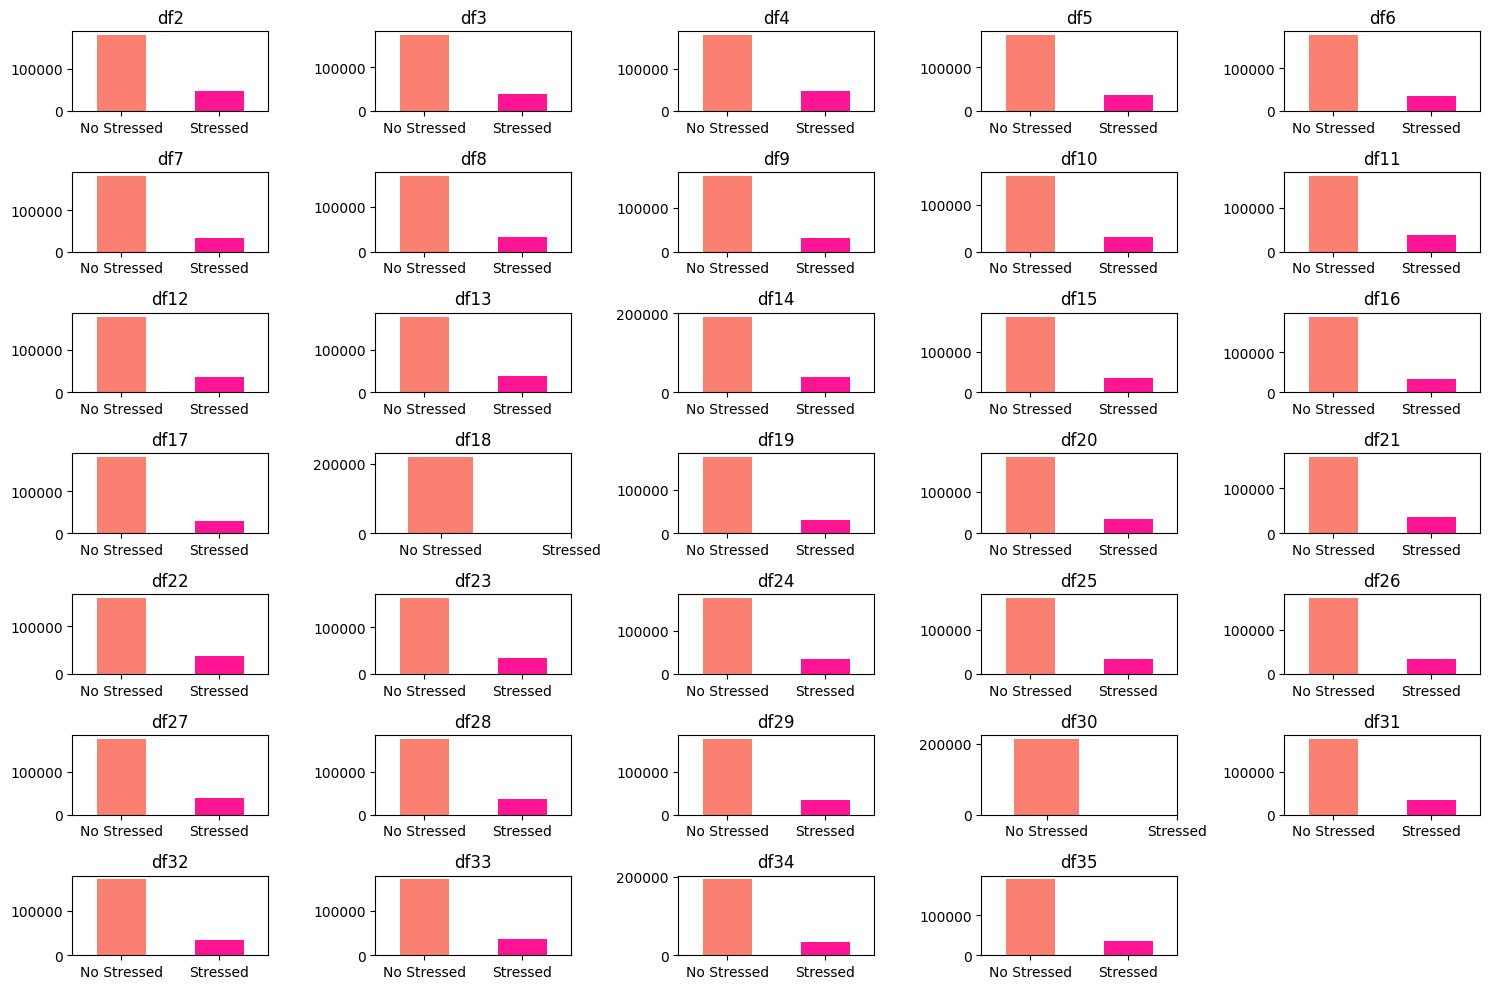

In [ ]:

# Define the subplots
fig, axs = plt.subplots(nrows=7, ncols=5, figsize=(15,10))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Iterate over the dataframes and plot the charts
for i, df_name in enumerate(data):
    # Select the dataframe
    df = data[df_name]
    
    # Count the values of the outcome column and plot the bar chart
    ax = axs[i]
    df["outcome"].value_counts().plot(kind="bar", color=["salmon","deeppink"], ax=ax)
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(('No Stressed', 'Stressed'), rotation=0)
    ax.set_title(df_name)

# Remove any extra subplots
for ax in axs[len(data):]:
    ax.remove()

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
to_remove = ['df18','df30']

# Create a new dictionary by iterating over the original dictionary and excluding the keys in to_remove list
data = {k:v for k,v in data.items() if k not in to_remove}


In [ ]:
#SMOTE balancing
# Define the SMOTE object
sm = SMOTE(random_state=42)

# Loop over each dataframe and balance the classes using SMOTE
for i, df_name in enumerate(data):
    # Select the dataframe
    df = data[df_name]
    
    # Separate features and target variable
    X = df.drop("outcome", axis=1)
    y = df["outcome"]
    
    # Apply SMOTE
    X_resampled, y_resampled = sm.fit_resample(X, y)
    
    # Update the original dataframe with the balanced data
    df_resampled = X_resampled.copy()
    df_resampled["outcome"] = y_resampled
    data[df_name] = df_resampled


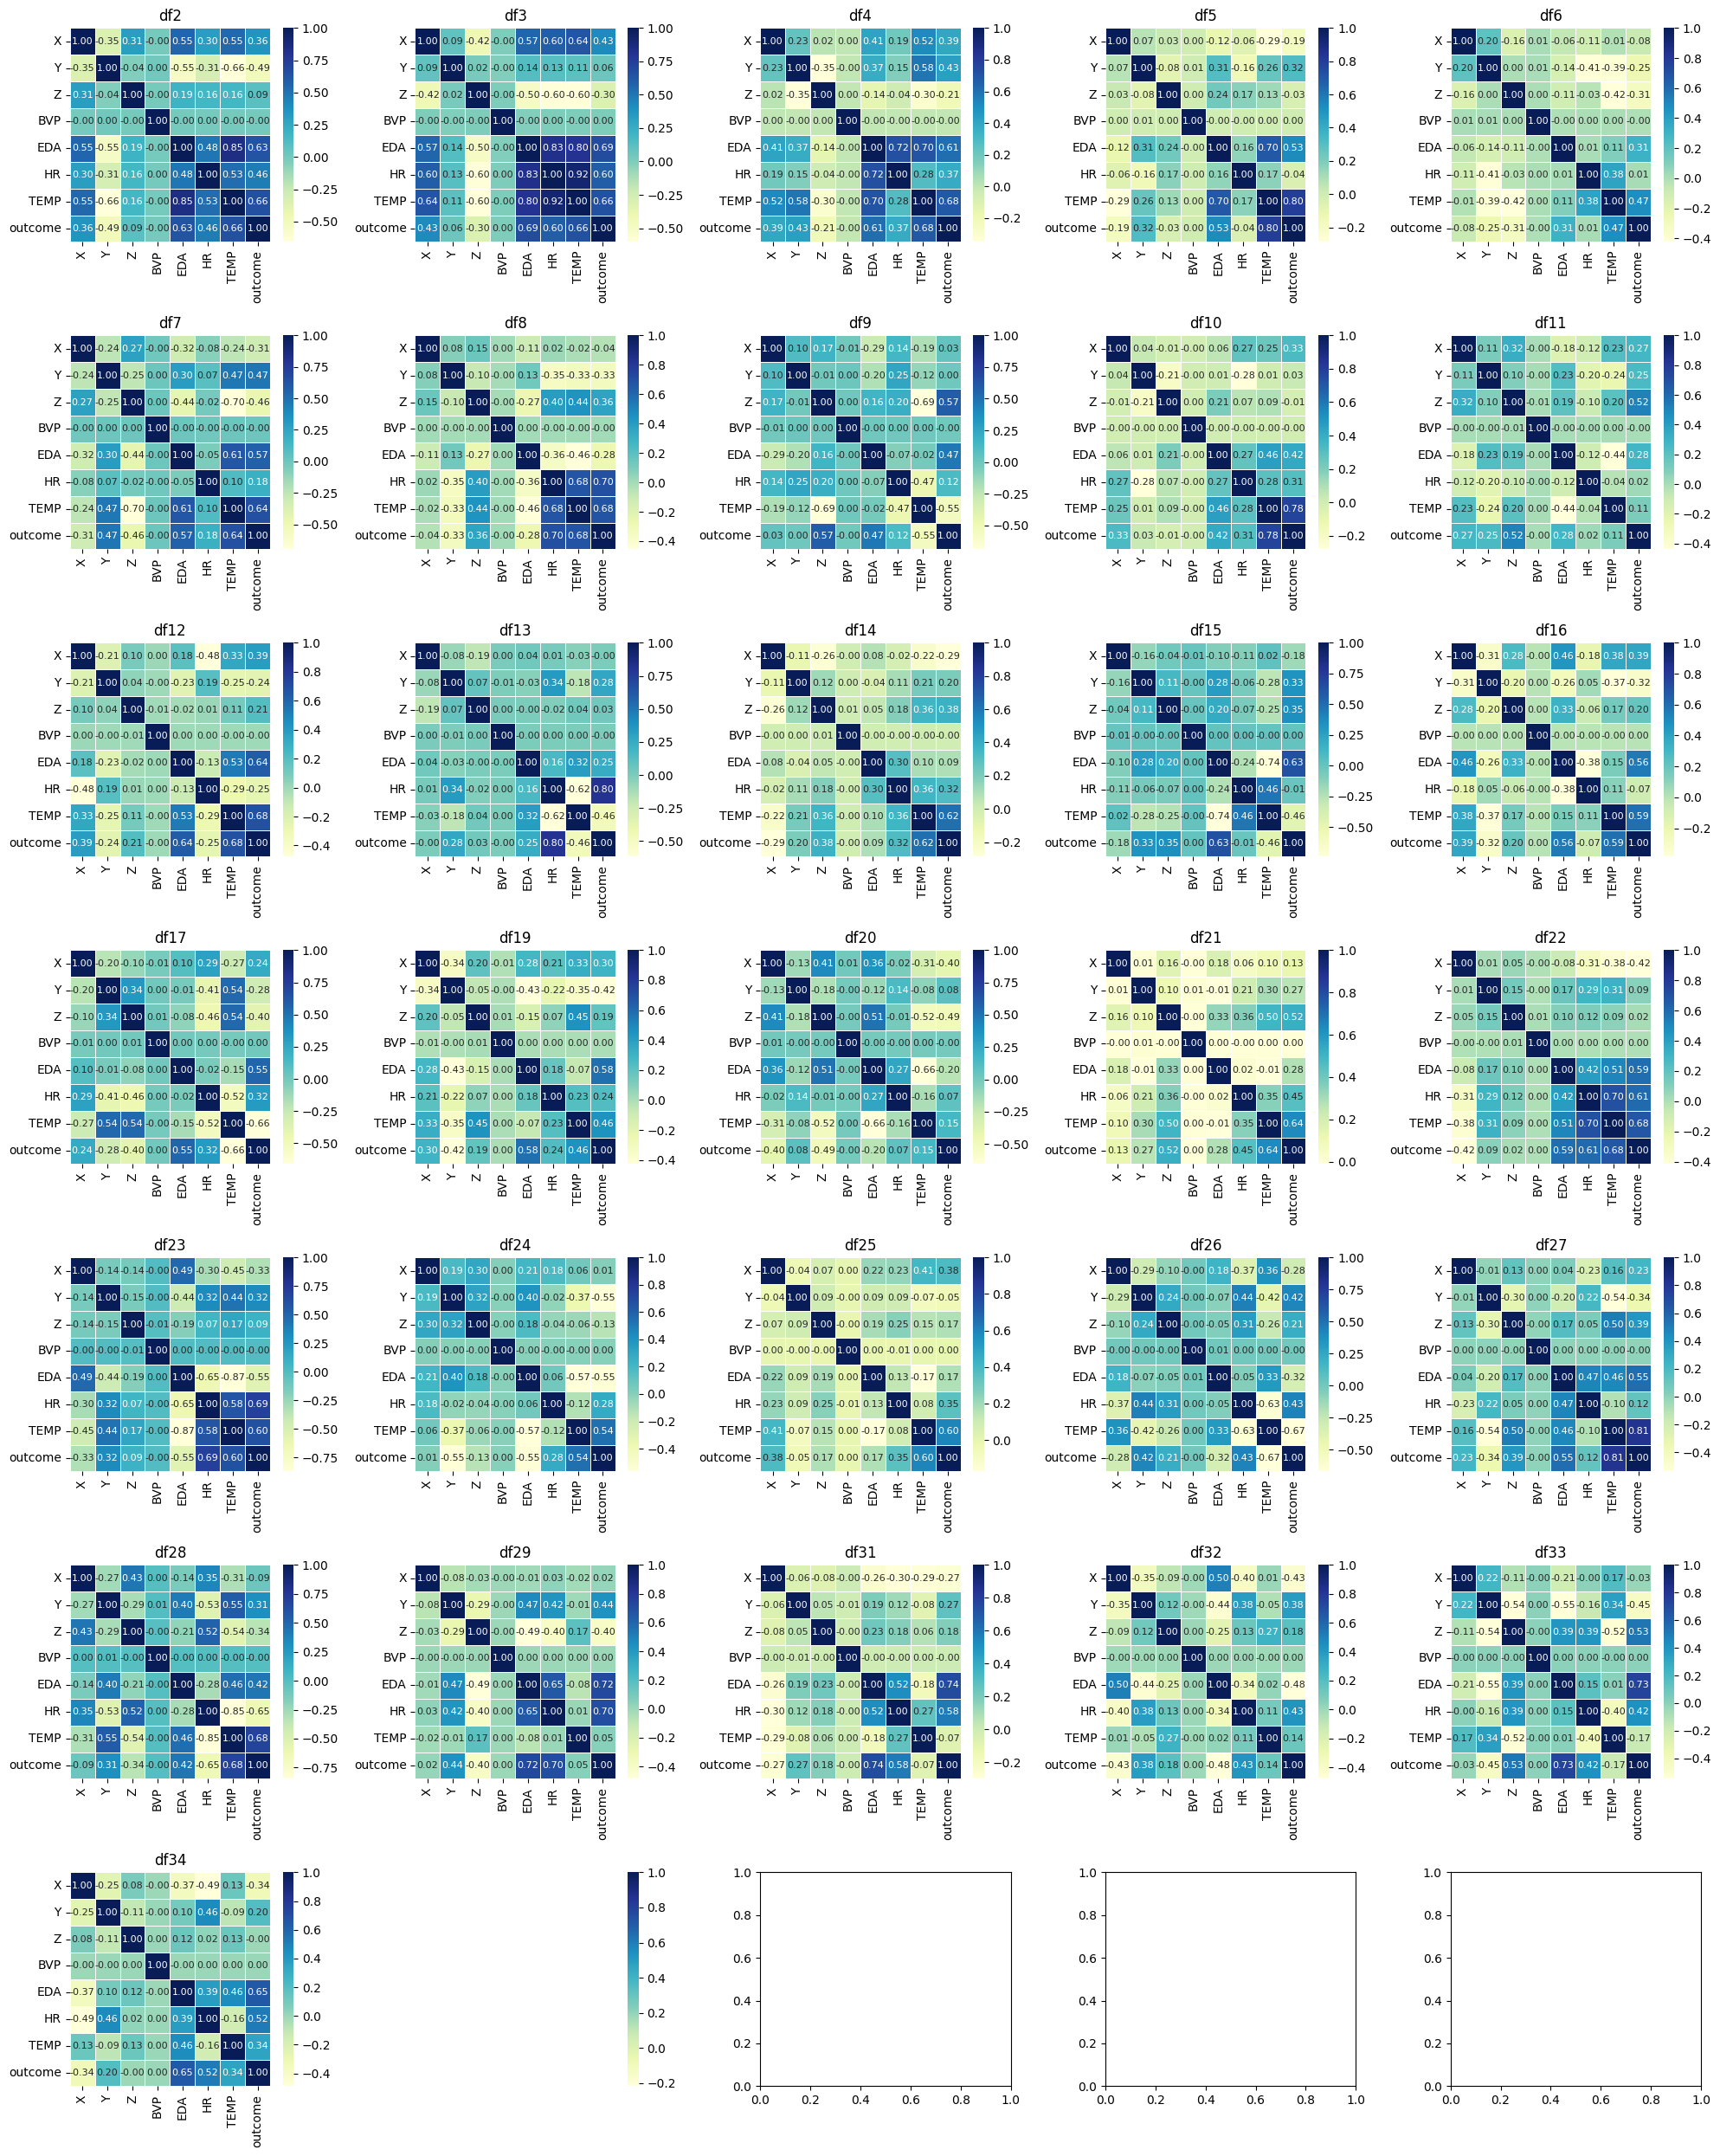

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the subplots
fig, axs = plt.subplots(nrows=7, ncols=5, figsize=(20, 25))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Iterate over the dataframes and plot the heatmaps
for i, df_name in enumerate(data):
    # Select the dataframe
    df = data[df_name]
    
    # Compute the correlation matrix and plot the heatmap
    ax = axs[i]
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix,
                annot=True,
                linewidth=0.5,
                annot_kws={"fontsize":8},
                fmt=".2f",
                cmap="YlGnBu",
                ax=ax)
    ax.set_title(df_name)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Hide any extra subplots
    if i >= len(data) - 1:
        ax.set_visible(False)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Remove BVP variable 
for df_name in data:
    data[df_name] = data[df_name].drop("BVP", axis=1)

for i in range(2, 36):
    if i in [18, 30]:
        continue
    globals()[f"df{i}"] = data[f"df{i}"]

In [ ]:
###################################### check furter for separate data sets (df2, df17, df28) #############################################################

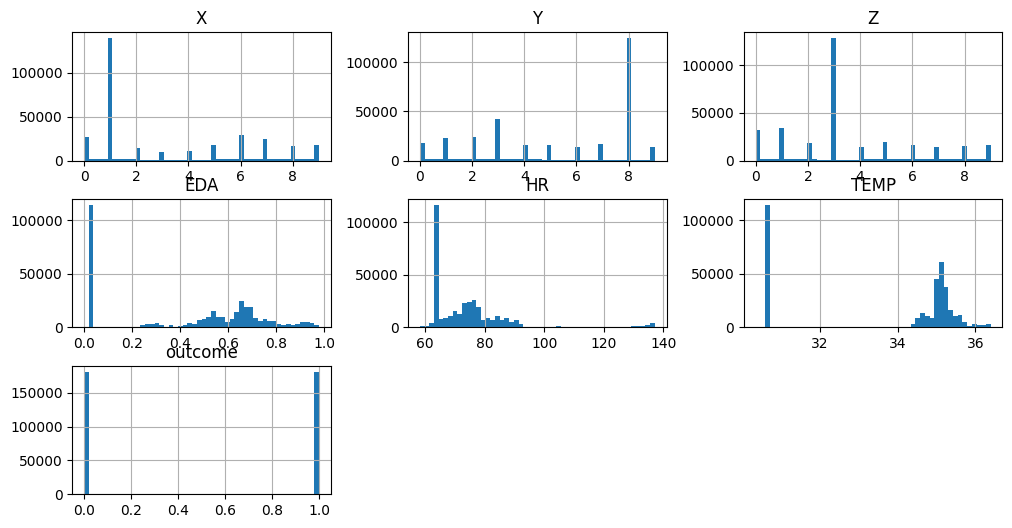

In [ ]:
_ = df2.hist(bins=50, figsize=(12,6))

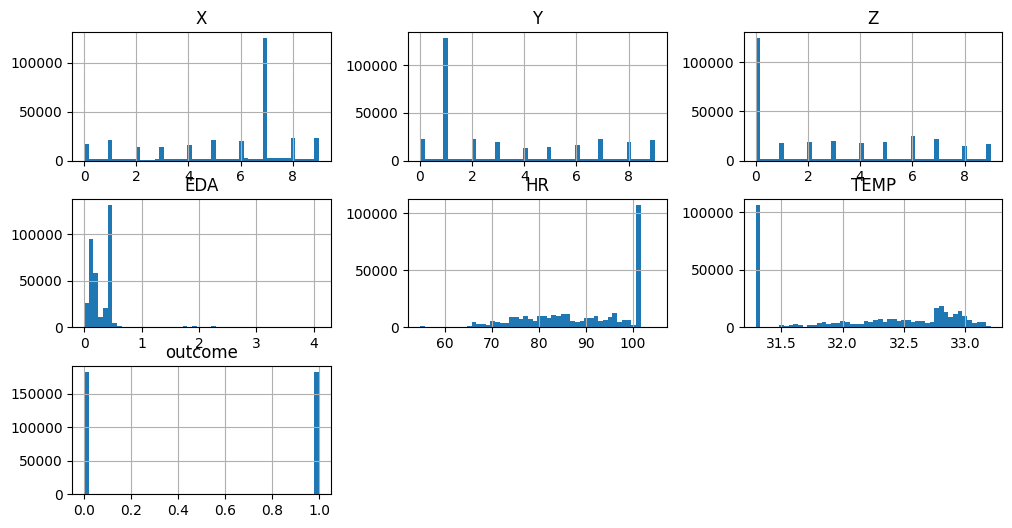

In [ ]:
_ = df17.hist(bins=50, figsize=(12,6))

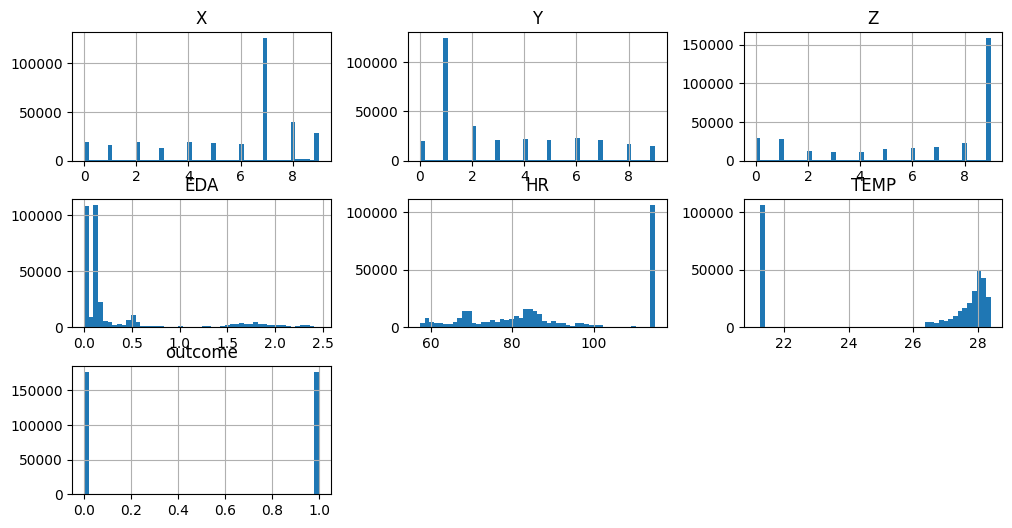

In [ ]:
_ = df28.hist(bins=50, figsize=(12,6))

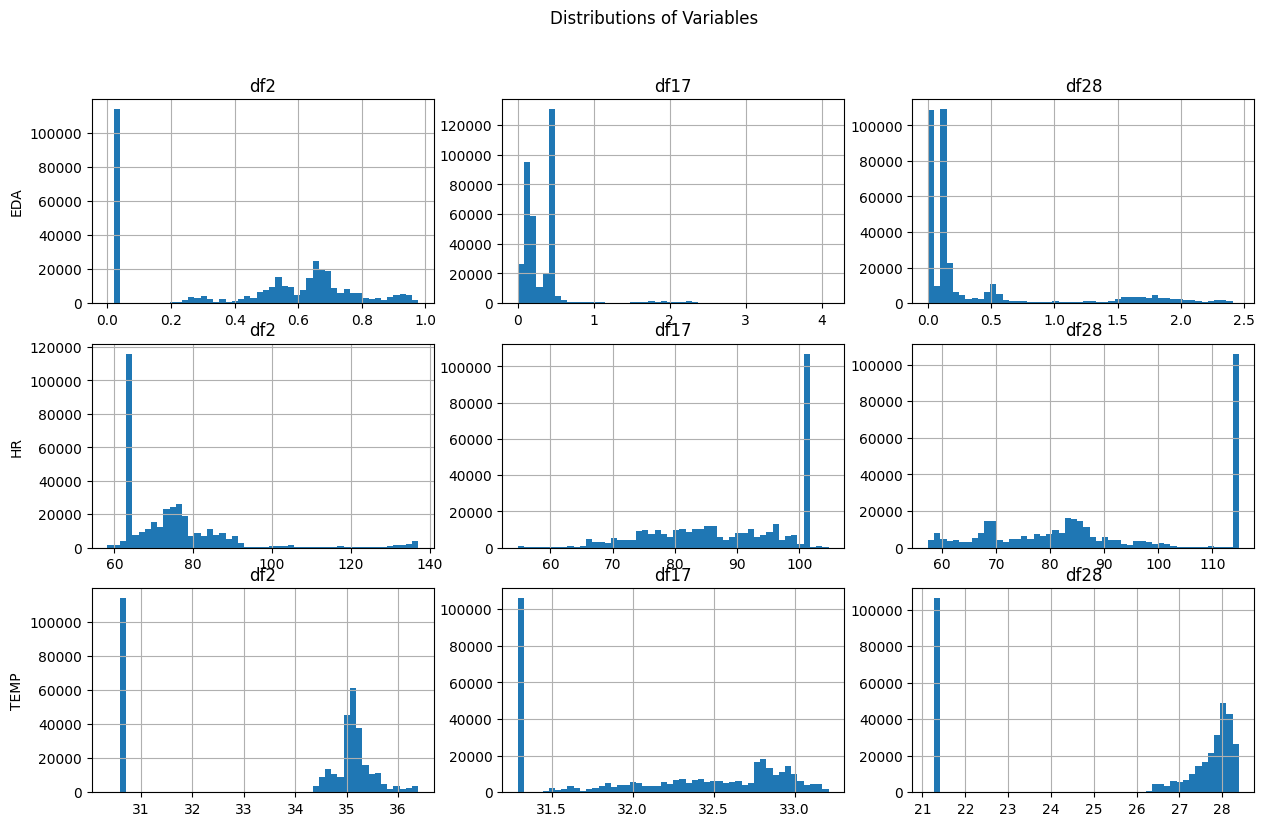

In [ ]:
variables = ['EDA', 'HR', 'TEMP']

fig, axs = plt.subplots(len(variables), 3, figsize=(15, len(variables)*3))

for i, var in enumerate(variables):
    _ = df2[var].hist(bins=50, ax=axs[i, 0])
    _ = df17[var].hist(bins=50, ax=axs[i, 1])
    _ = df28[var].hist(bins=50, ax=axs[i, 2])

    axs[i, 0].set_title('df2')
    axs[i, 1].set_title('df17')
    axs[i, 2].set_title('df28')
    axs[i, 0].set_ylabel(var)

fig.suptitle('Distributions of Variables')

plt.show()


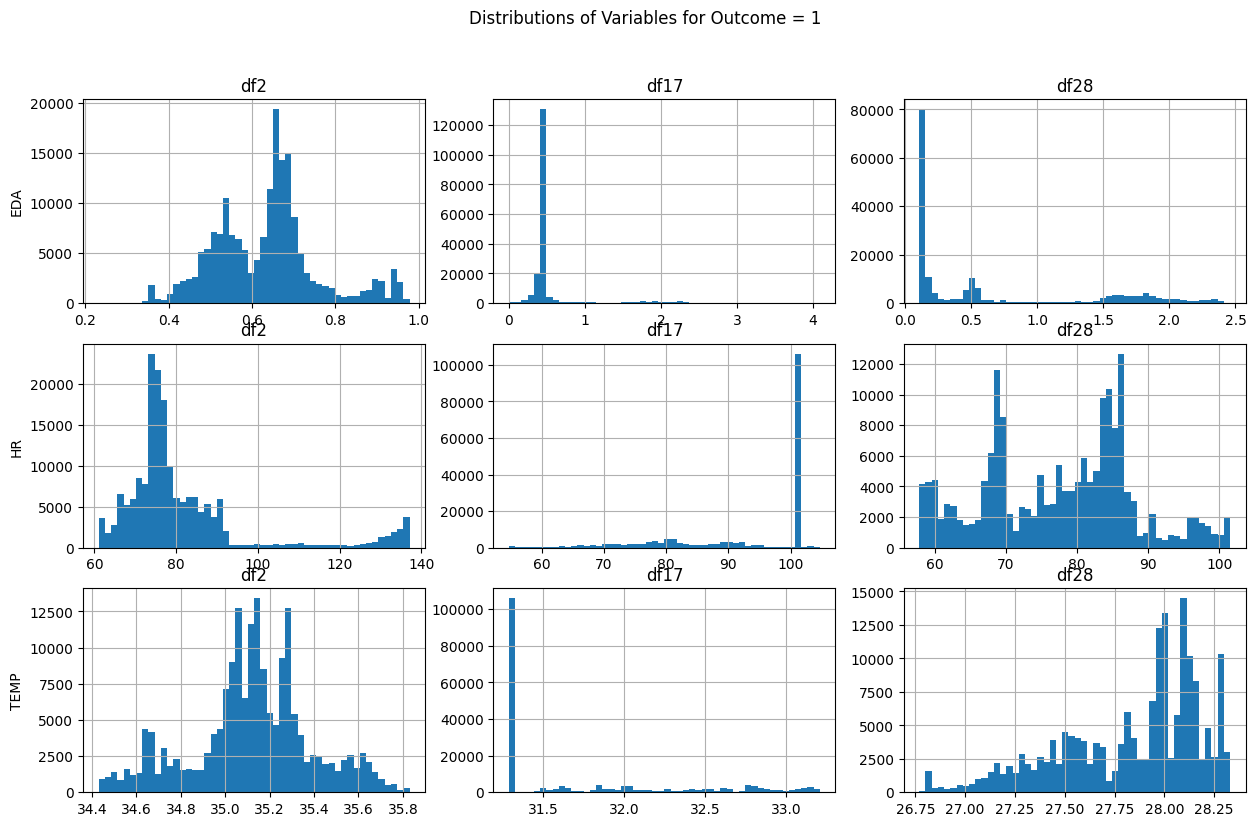

In [ ]:
variables = ['EDA', 'HR', 'TEMP']

fig, axs = plt.subplots(len(variables), 3, figsize=(15, len(variables)*3))

for i, var in enumerate(variables):
    _ = df2[var][df2.outcome == 1].hist(bins=50, ax=axs[i, 0])
    _ = df17[var][df17.outcome == 1].hist(bins=50, ax=axs[i, 1])
    _ = df28[var][df28.outcome == 1].hist(bins=50, ax=axs[i, 2])

    axs[i, 0].set_title('df2')
    axs[i, 1].set_title('df17')
    axs[i, 2].set_title('df28')
    axs[i, 0].set_ylabel(var)

fig.suptitle('Distributions of Variables for Outcome = 1')

plt.show()


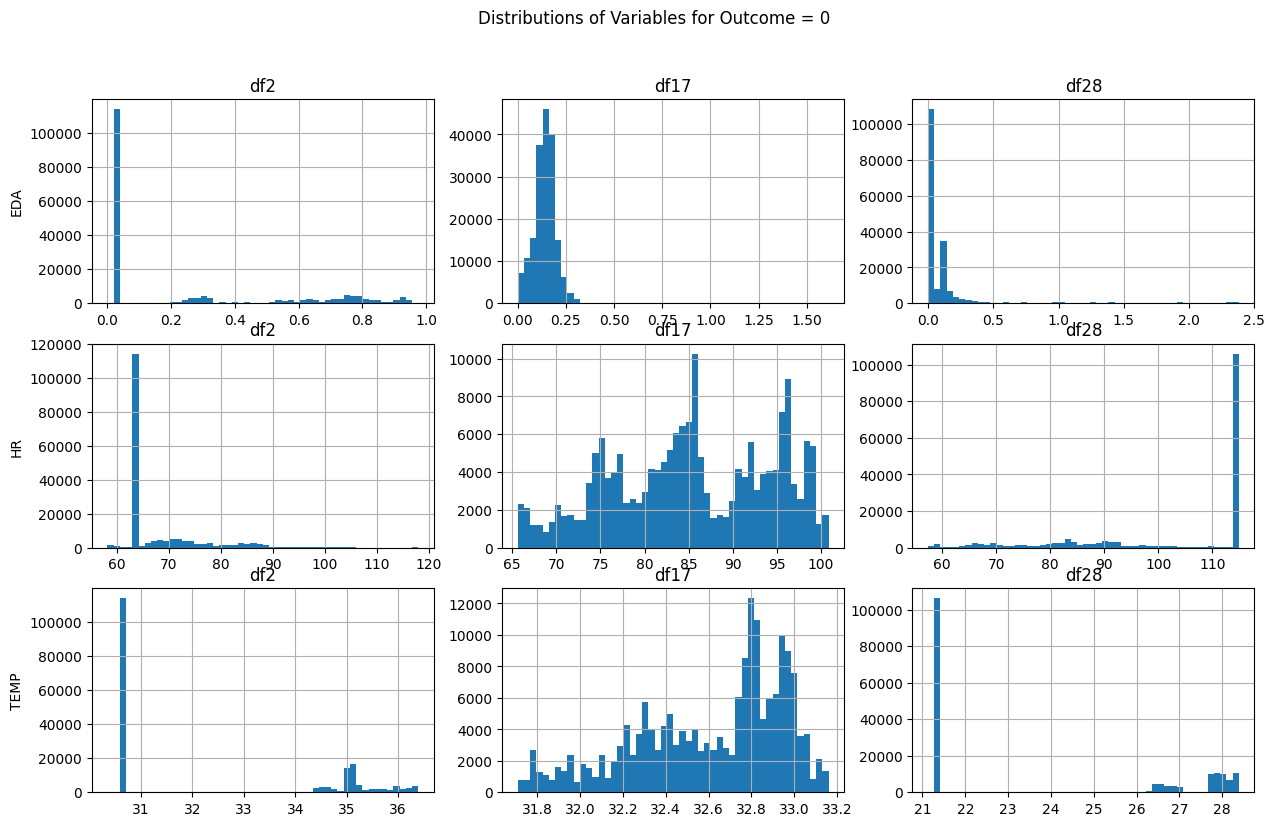

In [ ]:
variables = ['EDA', 'HR', 'TEMP']

fig, axs = plt.subplots(len(variables), 3, figsize=(15, len(variables)*3))

for i, var in enumerate(variables):
    _ = df2[var][df2.outcome == 0].hist(bins=50, ax=axs[i, 0])
    _ = df17[var][df17.outcome == 0].hist(bins=50, ax=axs[i, 1])
    _ = df28[var][df28.outcome == 0].hist(bins=50, ax=axs[i, 2])

    axs[i, 0].set_title('df2')
    axs[i, 1].set_title('df17')
    axs[i, 2].set_title('df28')
    axs[i, 0].set_ylabel(var)

fig.suptitle('Distributions of Variables for Outcome = 0')

plt.show()


In [ ]:
#################################### Modeling ####################################################################

# Modeling

In [ ]:
# Create a list of data frames
dfs = [df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df19, df20, df21, df22, df23, df24, df25, df26, df27, df28, df29, df31, df32, df33, df34, df35]


In [ ]:
X_train_data = []
X_test_data = []
y_train_data = []
y_test_data = []

# Train a logistic regression model for each data frame
for i, df in enumerate(dfs):
    # Split the data
    X = df.drop("outcome", axis=1)
    y = df["outcome"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Save the data
    X_train_data.append(X_train)
    X_test_data.append(X_test)
    y_train_data.append(y_train)
    y_test_data.append(y_test)

In [ ]:
# Train a logistic regression model for each data frame

scores_lr = []

for i in range(len(X_train_data)):
    # Train the model on this set of data
    log_reg = LogisticRegression(random_state=0)
    log_reg.fit(X_train_data[i], y_train_data[i])

    # Test the model on this set of data
    score = log_reg.score(X_test_data[i], y_test_data[i])
    scores_lr.append(score)
    print(f"Model LR {i+1} score: {score}")

# Calculate the average score
average_score_LR = np.mean(scores_lr)
print(f"Average score LR: {average_score_LR}")

Model LR 1 score: 0.8225924747104327
Model LR 2 score: 0.8418331442358787
Model LR 3 score: 0.8061264326148183
Model LR 4 score: 0.927437641723356
Model LR 5 score: 0.7795819731207869
Model LR 6 score: 0.8537002825472724
Model LR 7 score: 0.8806429649803144
Model LR 8 score: 0.8349930723934881
Model LR 9 score: 0.8874534199747467
Model LR 10 score: 0.7945679514954127
Model LR 11 score: 0.9142857142857143
Model LR 12 score: 0.9089237731579691
Model LR 13 score: 0.8647407465557169
Model LR 14 score: 0.8691554862474121
Model LR 15 score: 0.8801131910031752
Model LR 16 score: 0.9804050806728458
Model LR 17 score: 0.8992662728663987
Model LR 18 score: 0.7726926736441484
Model LR 19 score: 0.8255692439027981
Model LR 20 score: 0.8772215779080337
Model LR 21 score: 0.8491798763694228
Model LR 22 score: 0.8956717609489051
Model LR 23 score: 0.8600177653517393
Model LR 24 score: 0.8365922192288752
Model LR 25 score: 0.9181266042949519
Model LR 26 score: 0.8594828196953596
Model LR 27 score: 0.8

In [ ]:
# Train a KNN model for each data frame

scores_knn = []

for i, df in enumerate(dfs):
    
    # Train the model
    knn = KNeighborsClassifier()
    knn.fit(X_train_data[i], y_train_data[i])
    
    # Test the model on this set of data
    score = knn.score(X_test_data[i], y_test_data[i])
    scores_knn.append(score)
    print(f"Model KNN {i+1} score: {score}")

# Calculate the average score
average_score_KNN = np.mean(scores_knn)
print(f"Average score KNN: {average_score_KNN}")

Model KNN 1 score: 0.9454354233840278
Model KNN 2 score: 0.9331456720619282
Model KNN 3 score: 0.9771757619698279
Model KNN 4 score: 0.9791038778380551
Model KNN 5 score: 0.9855570158703241
Model KNN 6 score: 0.9842289719626168
Model KNN 7 score: 0.9811876498623486
Model KNN 8 score: 0.9875158757649232
Model KNN 9 score: 0.9931323334667858
Model KNN 10 score: 0.9789609898657982
Model KNN 11 score: 0.9946218487394958
Model KNN 12 score: 0.9776552114269552
Model KNN 13 score: 0.9777969671991731
Model KNN 14 score: 0.9572769069448552
Model KNN 15 score: 0.9318728328307051
Model KNN 16 score: 0.9647923103329901
Model KNN 17 score: 0.9771729336212939
Model KNN 18 score: 0.9494766888677451
Model KNN 19 score: 0.9866207444694661
Model KNN 20 score: 0.9729492524214024
Model KNN 21 score: 0.978073933533264
Model KNN 22 score: 0.9818231067518248
Model KNN 23 score: 0.9935782621991176
Model KNN 24 score: 0.9462790765041569
Model KNN 25 score: 0.985426339191786
Model KNN 26 score: 0.98027630180658

In [ ]:
# Train a Random Forest model for each data frame

scores_rf = []

for i, df in enumerate(dfs):
    
    # Train the model
    rf= RandomForestClassifier()
    rf.fit(X_train_data[i], y_train_data[i])
    
    # Test the model on this set of data
    score = rf.score(X_test_data[i], y_test_data[i])
    scores_rf.append(score)
    print(f"Model RF {i+1} score: {score}")

# Calculate the average score
average_score_RF = np.mean(scores_rf)
print(f"Average score RF: {average_score_RF}")

Model RF 1 score: 0.9972184935582525
Model RF 2 score: 0.997716468712749
Model RF 3 score: 0.9991913220490226
Model RF 4 score: 0.9994976893711071
Model RF 5 score: 0.9995760376478569
Model RF 6 score: 0.9991306237774397
Model RF 7 score: 0.9994375536544211
Model RF 8 score: 0.9996680521879691
Model RF 9 score: 0.9998460164454436
Model RF 10 score: 0.9997382846009567
Model RF 11 score: 0.9996078431372549
Model RF 12 score: 0.9981190779239146
Model RF 13 score: 0.9995944054114169
Model RF 14 score: 0.9994219342349366
Model RF 15 score: 0.9983260485445922
Model RF 16 score: 0.9995331273601099
Model RF 17 score: 0.9993992877268761
Model RF 18 score: 0.9988310452630148
Model RF 19 score: 0.9998380948175623
Model RF 20 score: 0.9986521643732564
Model RF 21 score: 0.9998316910459637
Model RF 22 score: 0.9995865647810219
Model RF 23 score: 0.9997233264893044
Model RF 24 score: 0.9991309637611888
Model RF 25 score: 0.9996633610592905
Model RF 26 score: 0.999419057739993
Model RF 27 score: 0.99

In [ ]:
# Train a  Gradient Boost model for each data frame

scores_gb = []

for i, df in enumerate(dfs):  
    
    # Train the model
    gb = GradientBoostingClassifier(random_state=0)
    gb.fit(X_train_data[i], y_train_data[i])
    
    # Test the model on this set of data
    score = gb.score(X_test_data[i], y_test_data[i])
    scores_gb.append(score)
    print(f"Model GB {i+1} score: {score}")

# Calculate the average score
average_score_GB = np.mean(scores_gb)
print(f"Average score GB: {average_score_GB}")

Model GB 1 score: 0.9624980972281804
Model GB 2 score: 0.9600453833891052
Model GB 3 score: 0.9729371740888431
Model GB 4 score: 0.9856913229426791
Model GB 5 score: 0.9887367335113976
Model GB 6 score: 0.9827618995870463
Model GB 7 score: 0.9916669133536603
Model GB 8 score: 0.9893199399607435
Model GB 9 score: 0.994733762434172
Model GB 10 score: 0.9938933073556567
Model GB 11 score: 0.995406162464986
Model GB 12 score: 0.9772875123744873
Model GB 13 score: 0.9874789025395455
Model GB 14 score: 0.9770386900760896
Model GB 15 score: 0.9712239773617993
Model GB 16 score: 0.9960178510127017
Model GB 17 score: 0.9886293748301558
Model GB 18 score: 0.9750305831181187
Model GB 19 score: 0.996629428474706
Model GB 20 score: 0.9831363821584177
Model GB 21 score: 0.9919517718342615
Model GB 22 score: 0.9922730383211679
Model GB 23 score: 0.9945830238958543
Model GB 24 score: 0.978245126155094
Model GB 25 score: 0.9875443591937497
Model GB 26 score: 0.9759121501948282
Model GB 27 score: 0.9794

In [ ]:
model_compare = pd.DataFrame({"Logistic Regression":average_score_LR,
                            "KNN":average_score_KNN,
                            "Random Forest":average_score_RF,
                           "Gradient Boost":average_score_GB
                            },index=["accuracy"])

<Axes: >

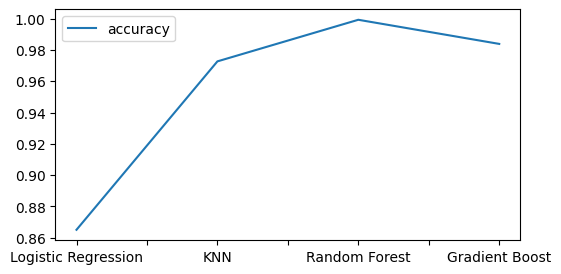

In [ ]:
model_compare.T.plot(kind='line', figsize=(6, 3))

# Hyperparameter tuning using RandomizedSearchcv

# Best Model is Random Forest with 99.92% accuracy:

In [ ]:
#saving model 

joblib.dump(rf, 'C:\\Users\\USER\\Desktop\\Decision making\\rf.pkl')


['C:\\Users\\USER\\Desktop\\Decision making\\rf.pkl']

In [ ]:
y_preds_data = []

for i, df in enumerate(dfs):
    y_preds = rf.predict(X_test_data[i])
    y_preds_data.append(y_preds)

In [ ]:
y_test_data_array = []

# loop through the dataframes and convert each one to a numpy array
for df in y_test_data:
    arr = df.values
    y_test_data_array.append(arr)

In [ ]:
y_test_data_array

[array([0, 1, 1, ..., 1, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([0, 1, 1, ..., 0, 0, 1]),
 array([1, 0, 1, ..., 1, 0, 0]),
 array([0, 1, 0, ..., 0, 1, 1]),
 array([1, 1, 1, ..., 1, 0, 1]),
 array([1, 1, 1, ..., 1, 0, 1]),
 array([0, 0, 0, ..., 1, 1, 0]),
 array([1, 1, 1, ..., 0, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 0, 1, ..., 1, 1, 1]),
 array([0, 0, 1, ..., 1, 1, 1]),
 array([1, 1, 0, ..., 0, 1, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([0, 1, 0, ..., 1, 0, 1]),
 array([0, 1, 0, ..., 1, 0, 1]),
 array([1, 1, 0, ..., 1, 1, 1]),
 array([0, 1, 1, ..., 1, 0, 1]),
 array([0, 0, 0, ..., 1, 0, 1]),
 array([1, 1, 1, ..., 1, 1, 0]),
 array([0, 1, 0, ..., 1, 0, 1]),
 array([0, 1, 1, ..., 0, 0, 0]),
 array([0, 0, 1, ..., 0, 0, 0]),
 array([1, 0, 1, ..., 0, 1, 0]),
 array([0, 1, 1, ..., 1, 0, 0]),
 array([1, 1, 0, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([1, 1, 1, ..., 1, 1, 0]),
 array([1, 1, 1, ..., 0, 1, 1]),
 array([1, 0, 0, ..., 0, 1, 1]),
 array([0,

In [ ]:
# loop over the dataframes and corresponding predictions
for i, (X_test, y_test, y_preds) in enumerate(zip(X_test_data, y_test_data, y_preds_data)):
    # compute the confusion matrix
    cm = confusion_matrix(y_test, y_preds)
    print(f"Confusion matrix for model {i+1}:")
    print(cm)


Confusion matrix for model 1:
[[35451   807]
 [35082   923]]
Confusion matrix for model 2:
[[34856    37]
 [34707    29]]
Confusion matrix for model 3:
[[35426   598]
 [34185  1513]]
Confusion matrix for model 4:
[[  485 34408]
 [ 3794 30991]]
Confusion matrix for model 5:
[[35379    34]
 [34423   925]]
Confusion matrix for model 6:
[[30110  6808]
 [14064 22634]]
Confusion matrix for model 7:
[[33727    75]
 [33760     0]]
Confusion matrix for model 8:
[[ 8760 25932]
 [22729 11867]]
Confusion matrix for model 9:
[[28409  4170]
 [ 6090 26273]]
Confusion matrix for model 10:
[[32524  2046]
 [29809  4398]]
Confusion matrix for model 11:
[[ 9128 26587]
 [29546  6139]]
Confusion matrix for model 12:
[[34929   540]
 [35034   207]]
Confusion matrix for model 13:
[[11178 27244]
 [27156 10853]]
Confusion matrix for model 14:
[[36540   929]
 [23105 13812]]
Confusion matrix for model 15:
[[33951  3864]
 [16948 20508]]
Confusion matrix for model 16:
[[35708   475]
 [32597  4045]]
Confusion matrix 

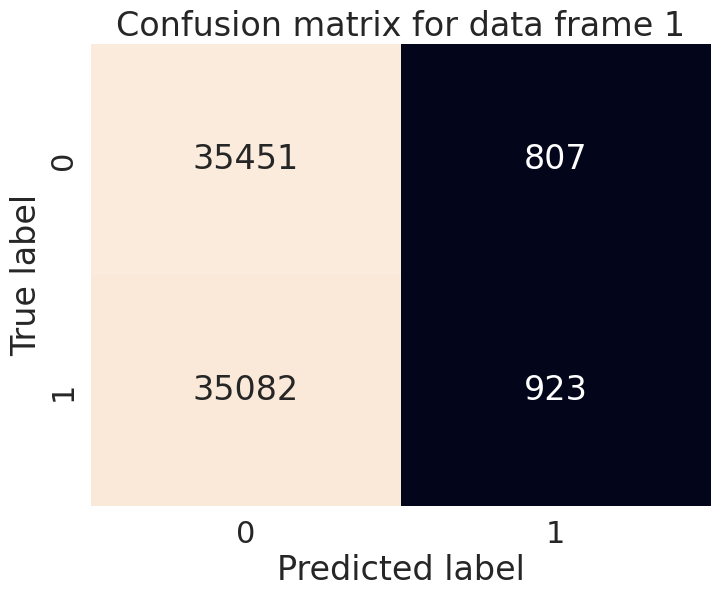

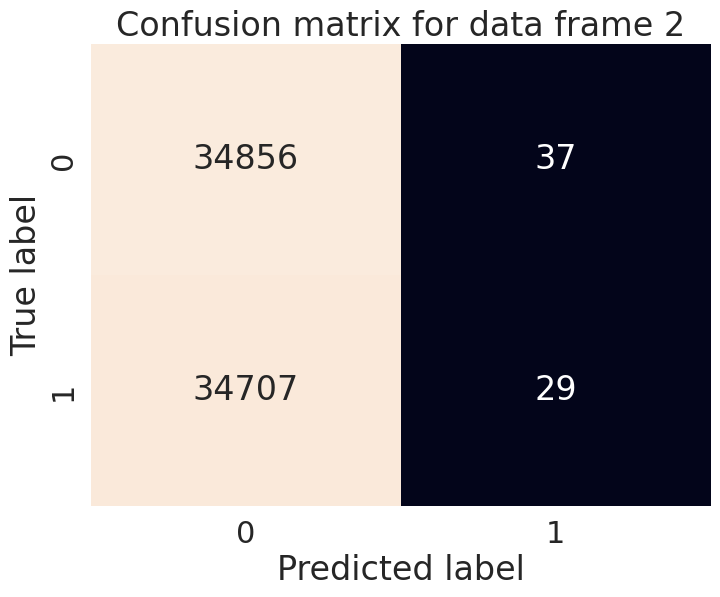

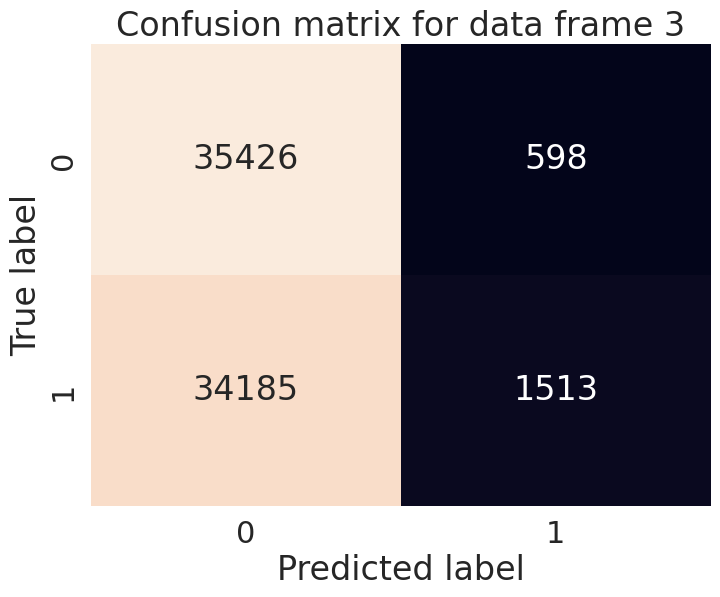

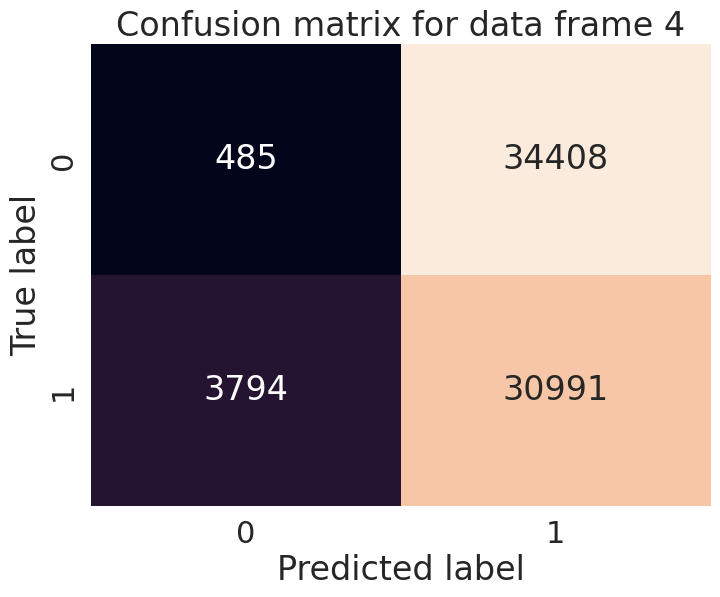

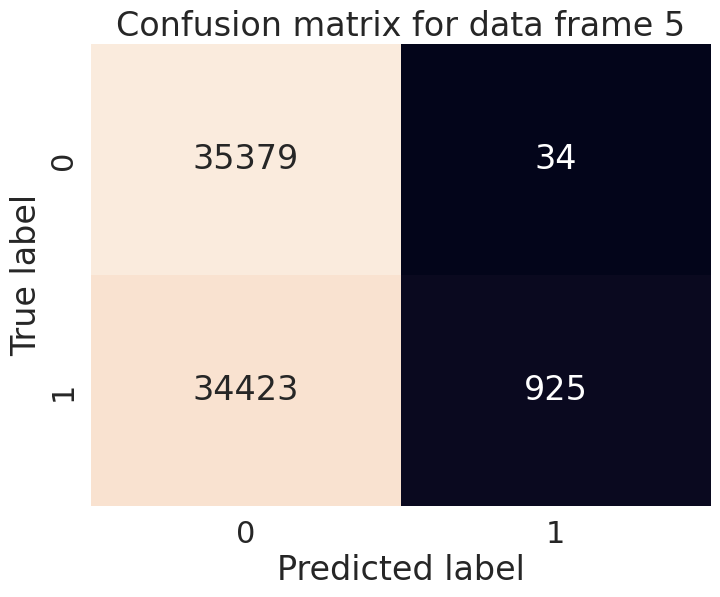

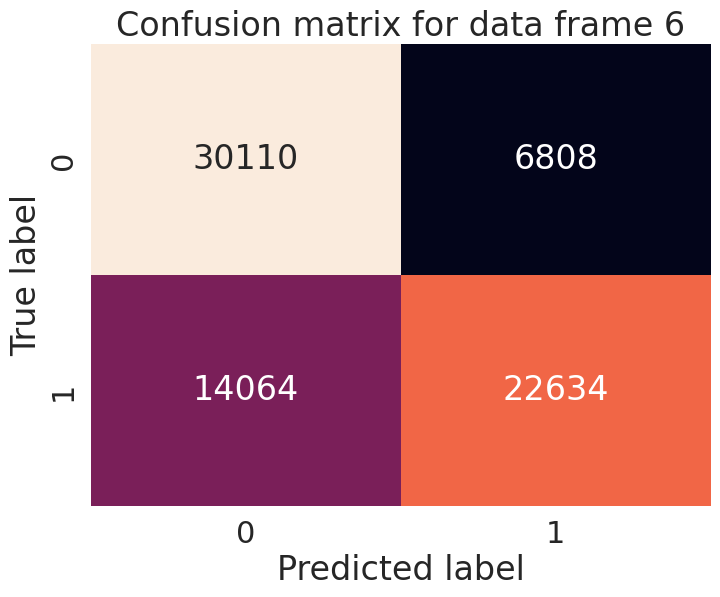

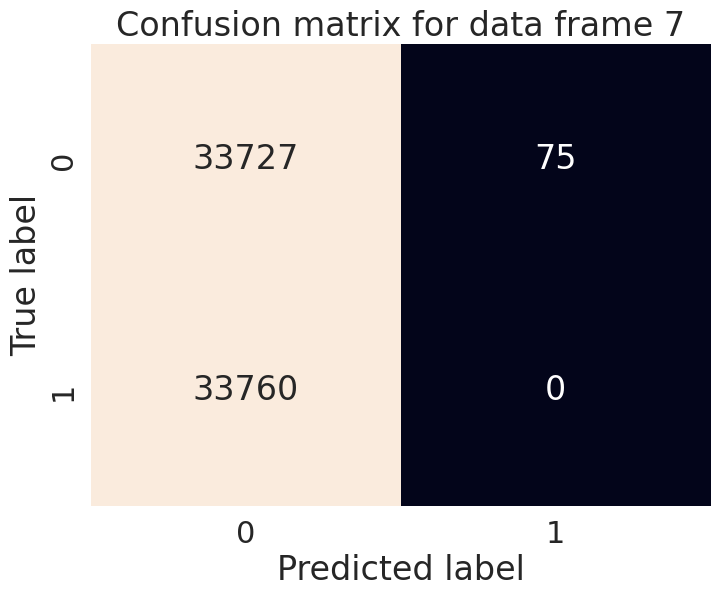

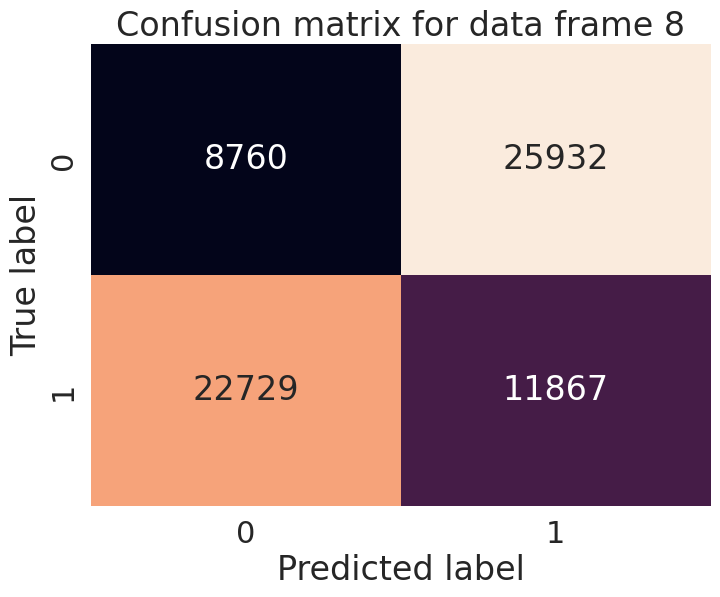

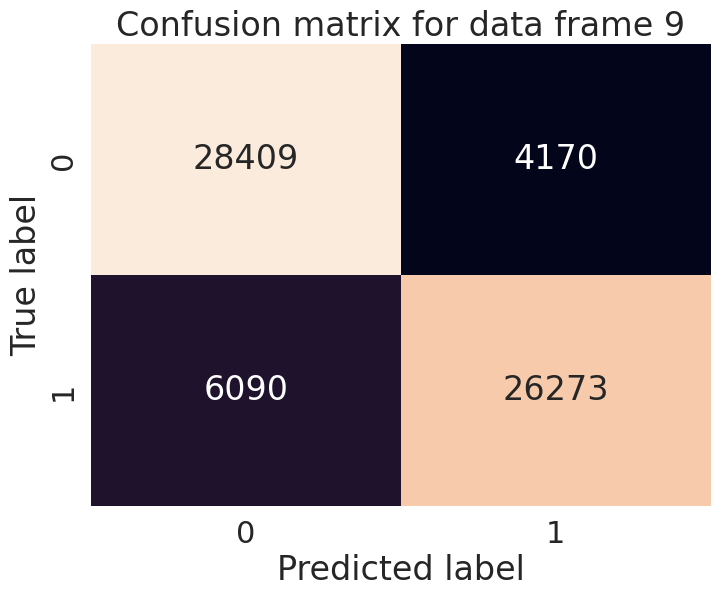

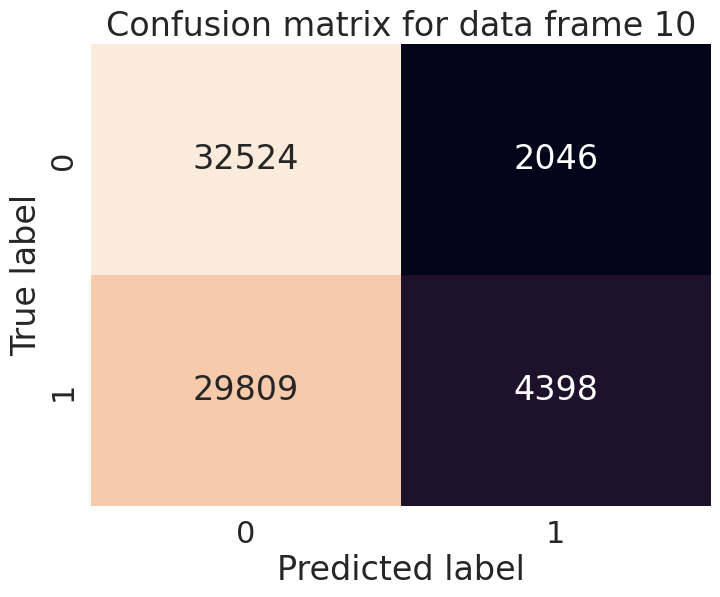

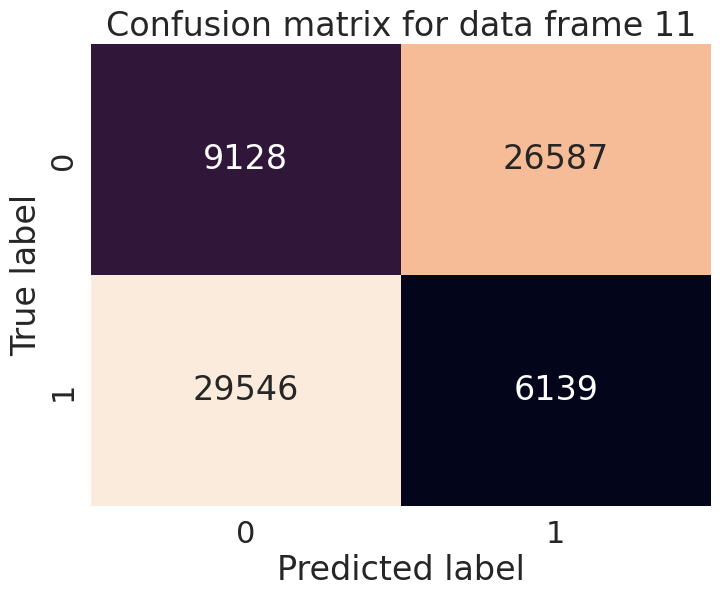

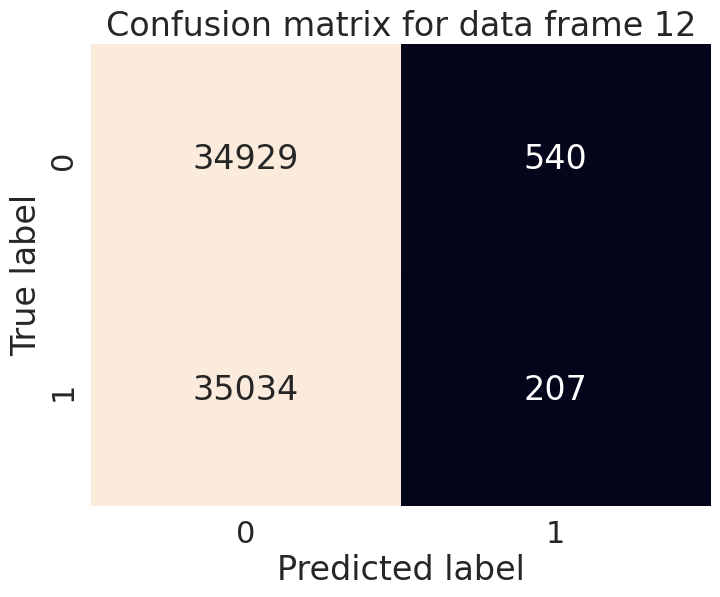

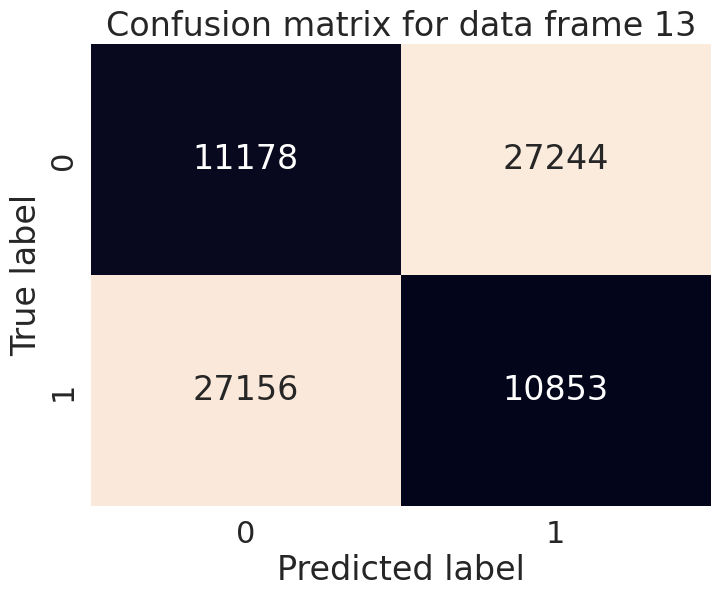

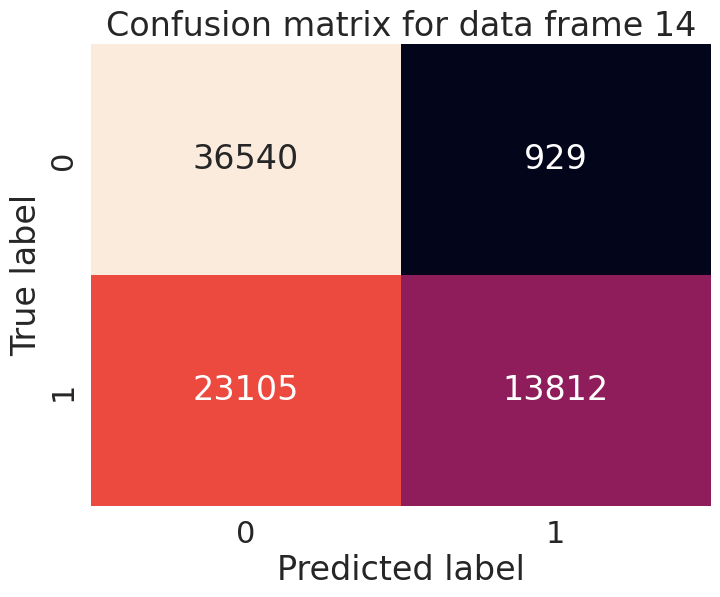

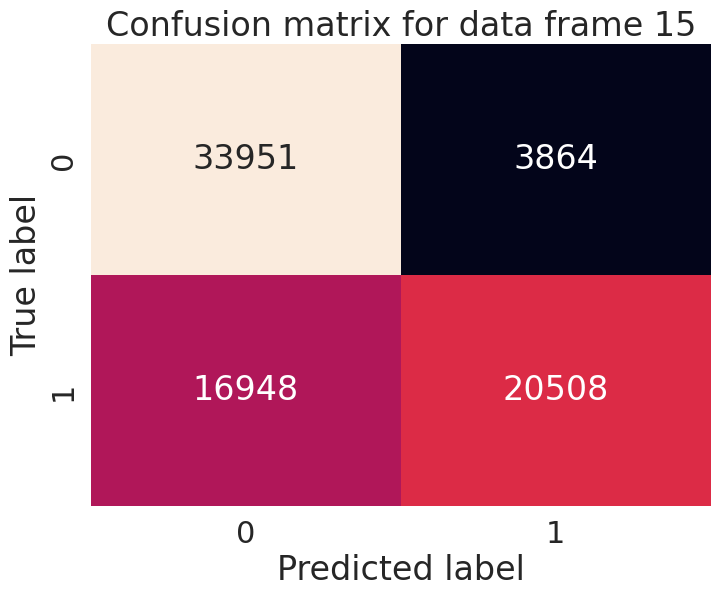

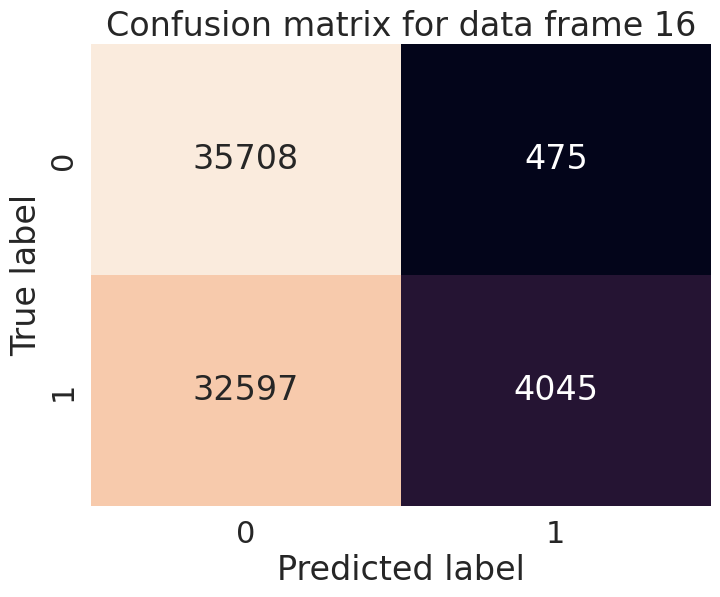

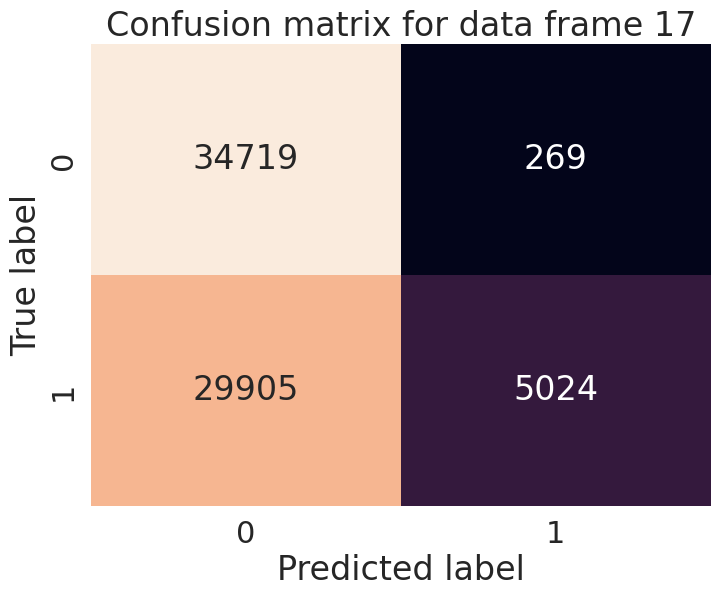

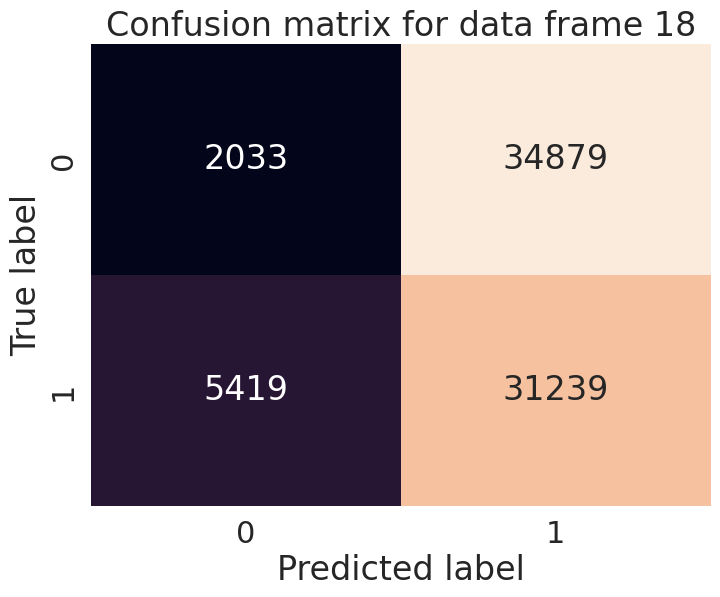

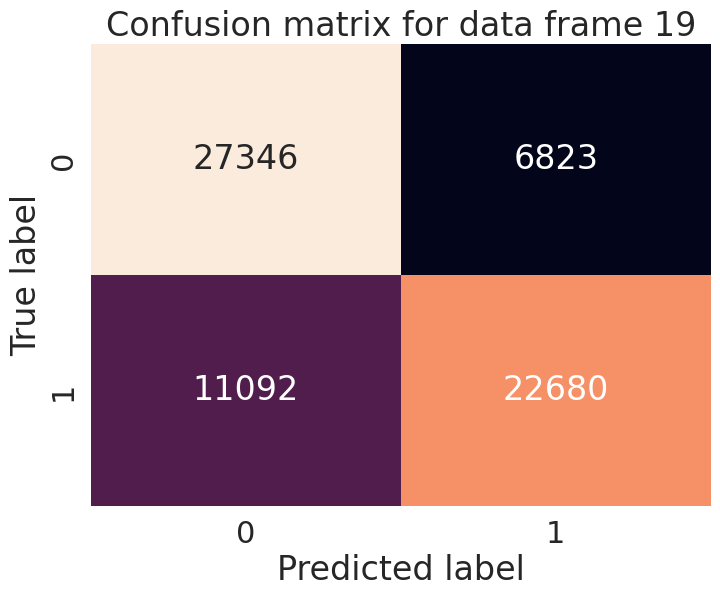

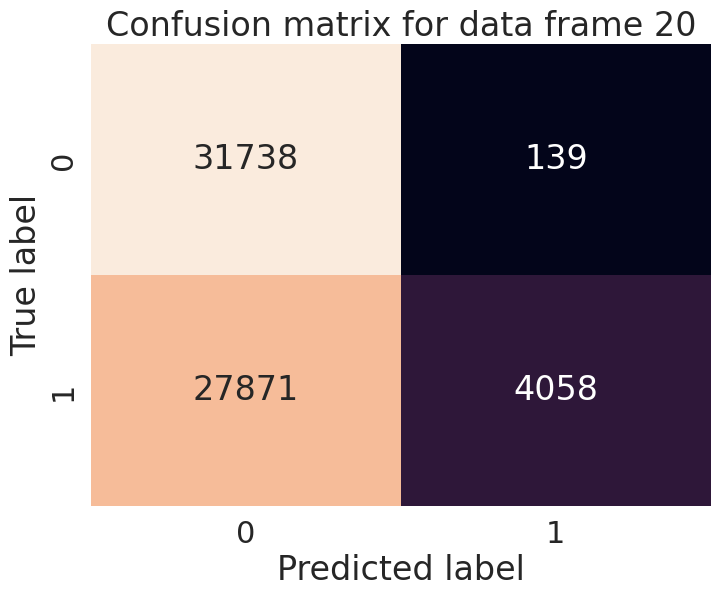

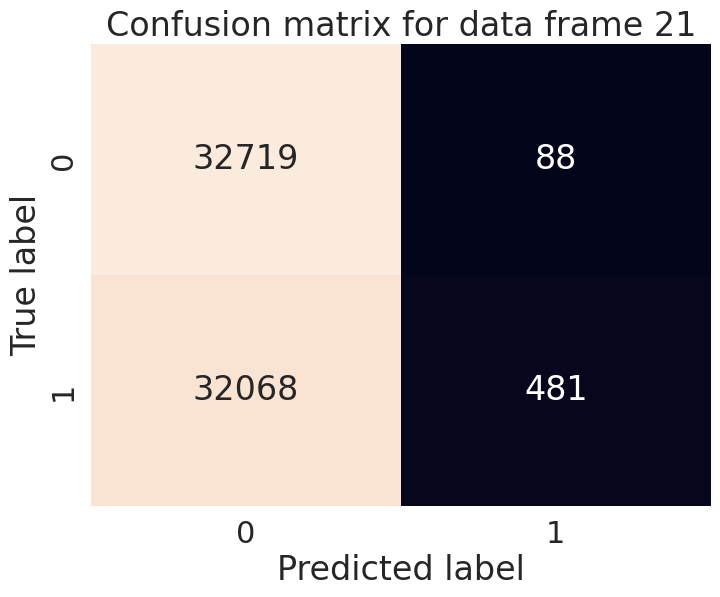

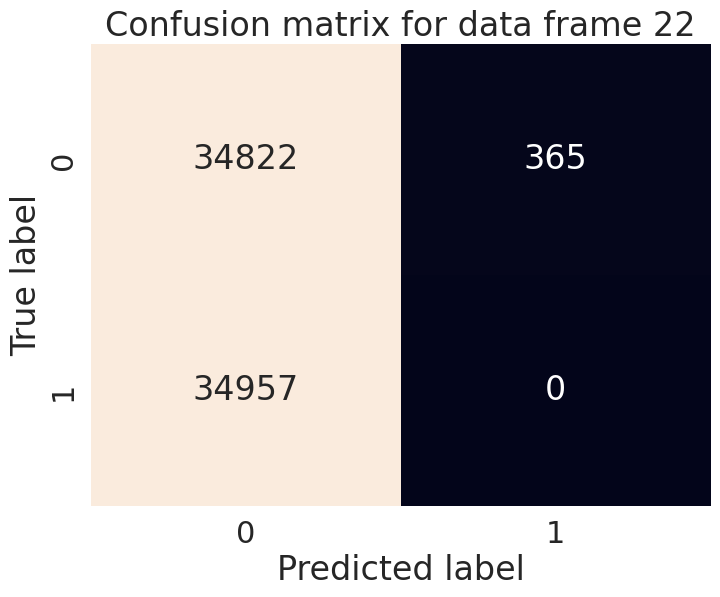

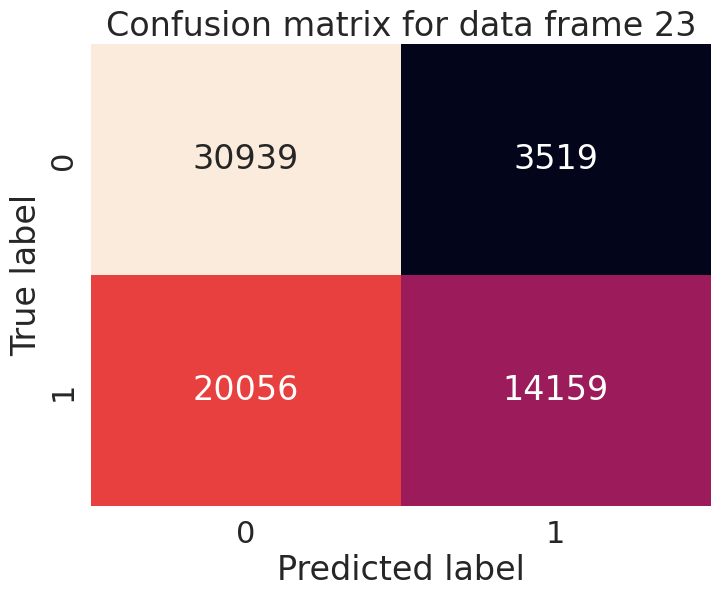

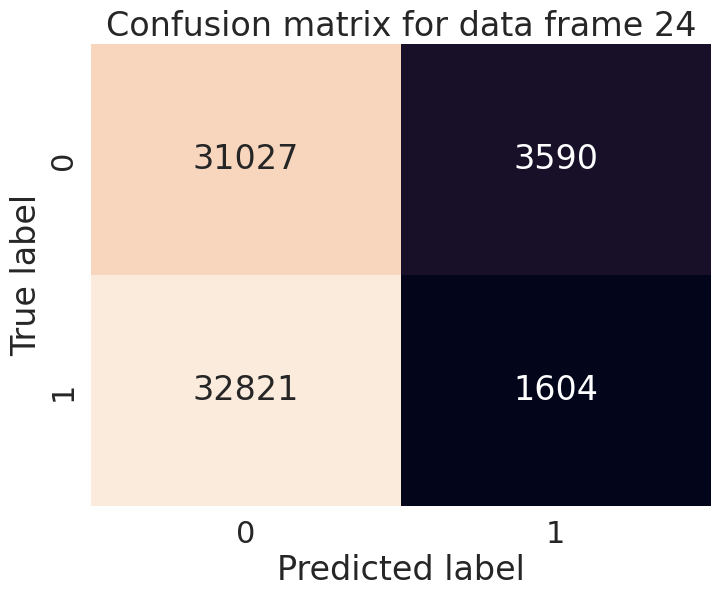

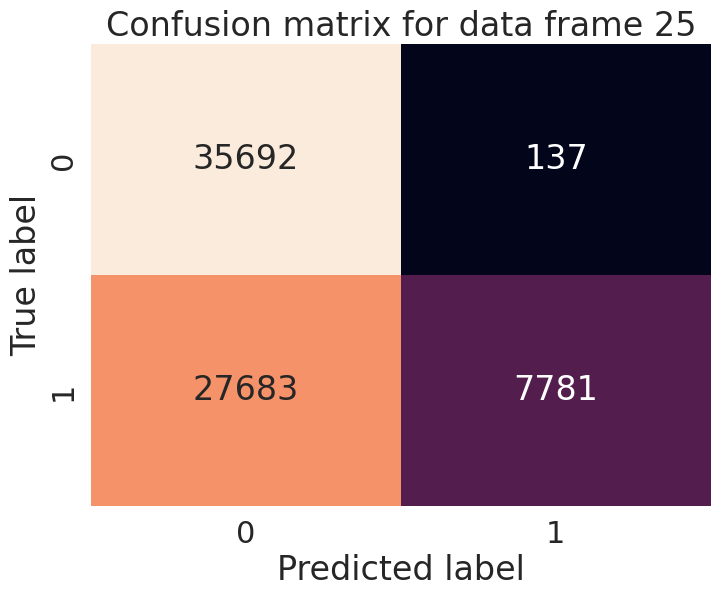

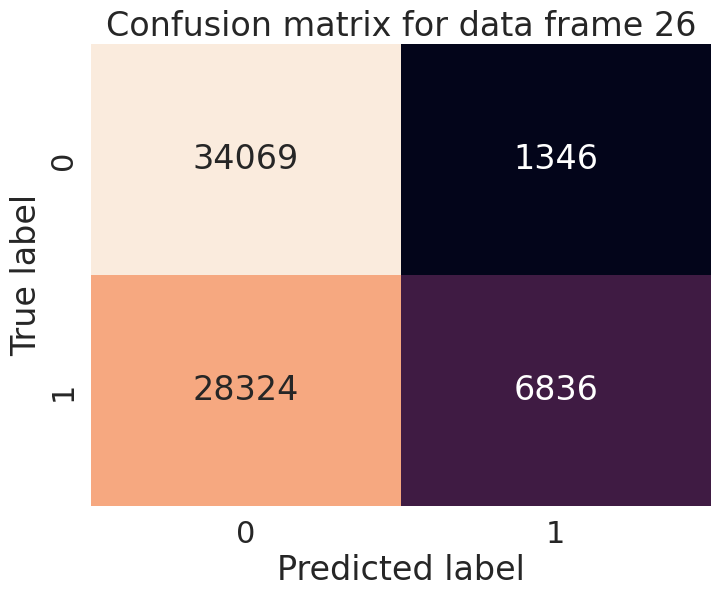

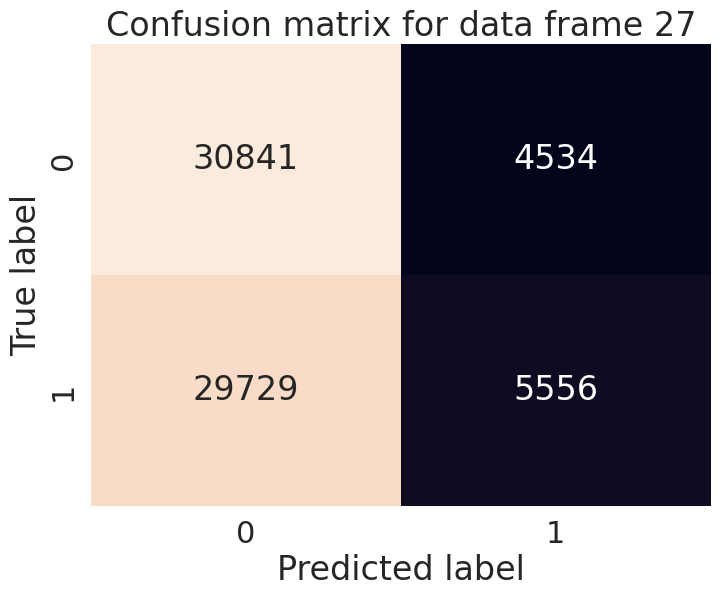

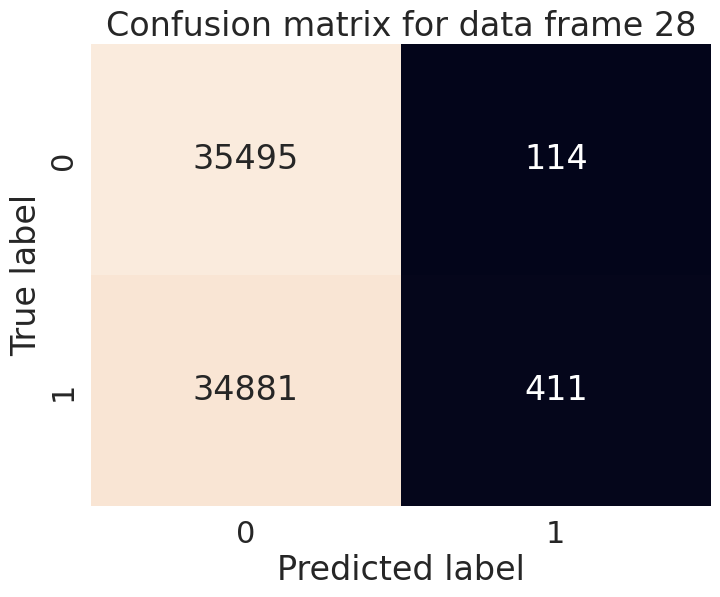

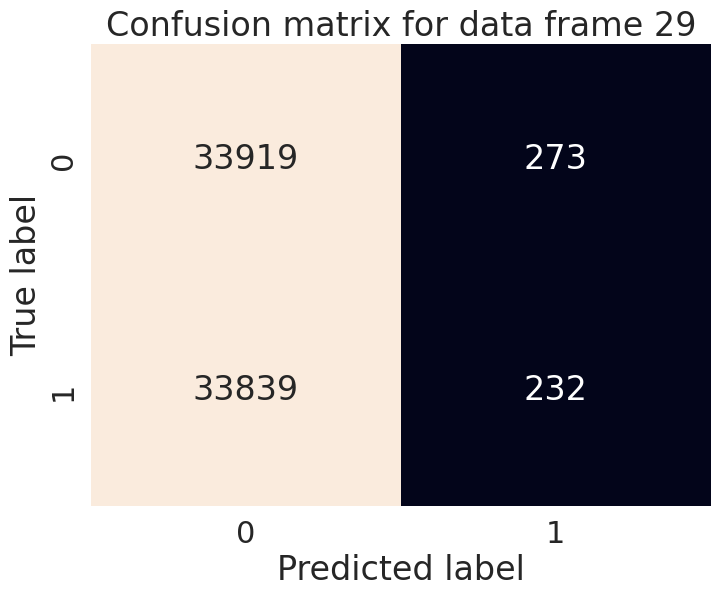

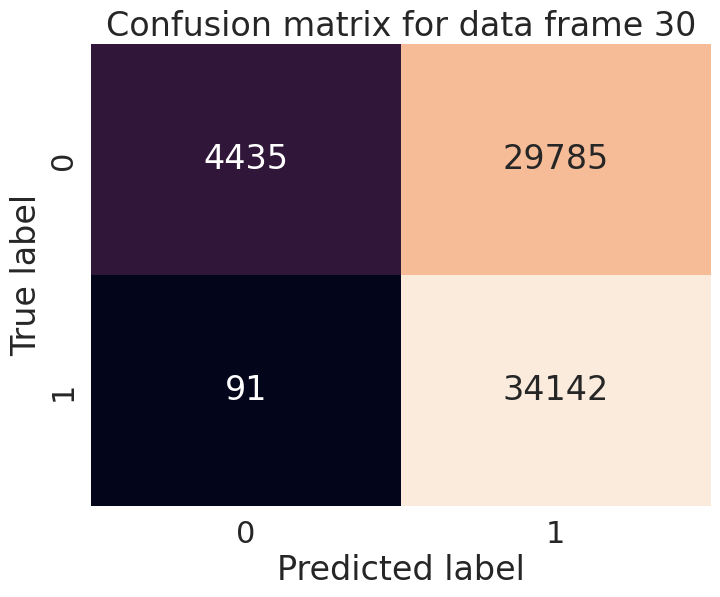

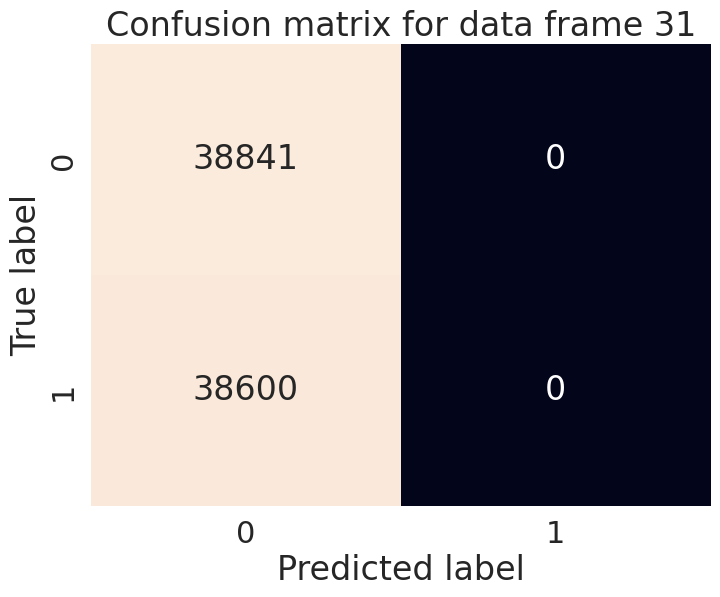

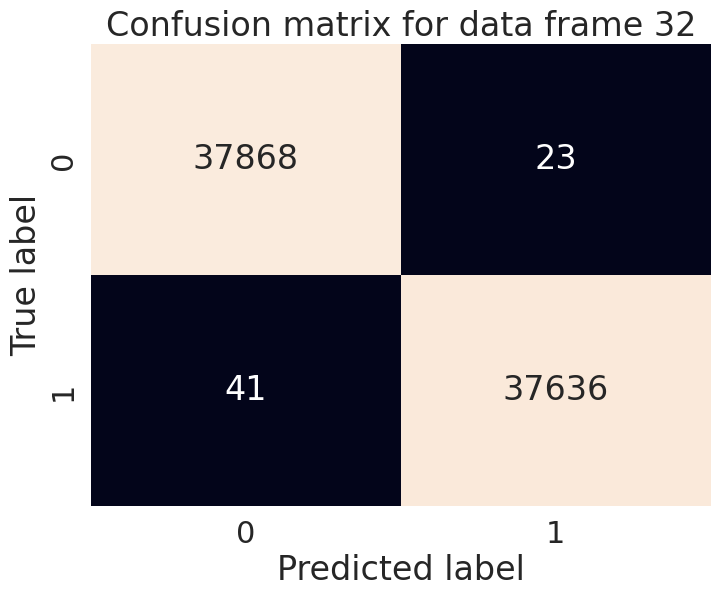

In [ ]:
sns.set(font_scale=2)

for i in range(len(X_test_data)):
    # Predict on test data
    y_preds = rf.predict(X_test_data[i])

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_data[i], y_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cbar=False, fmt='g')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Confusion matrix for data frame {i+1}")
    plt.show()

IndexError: ignored

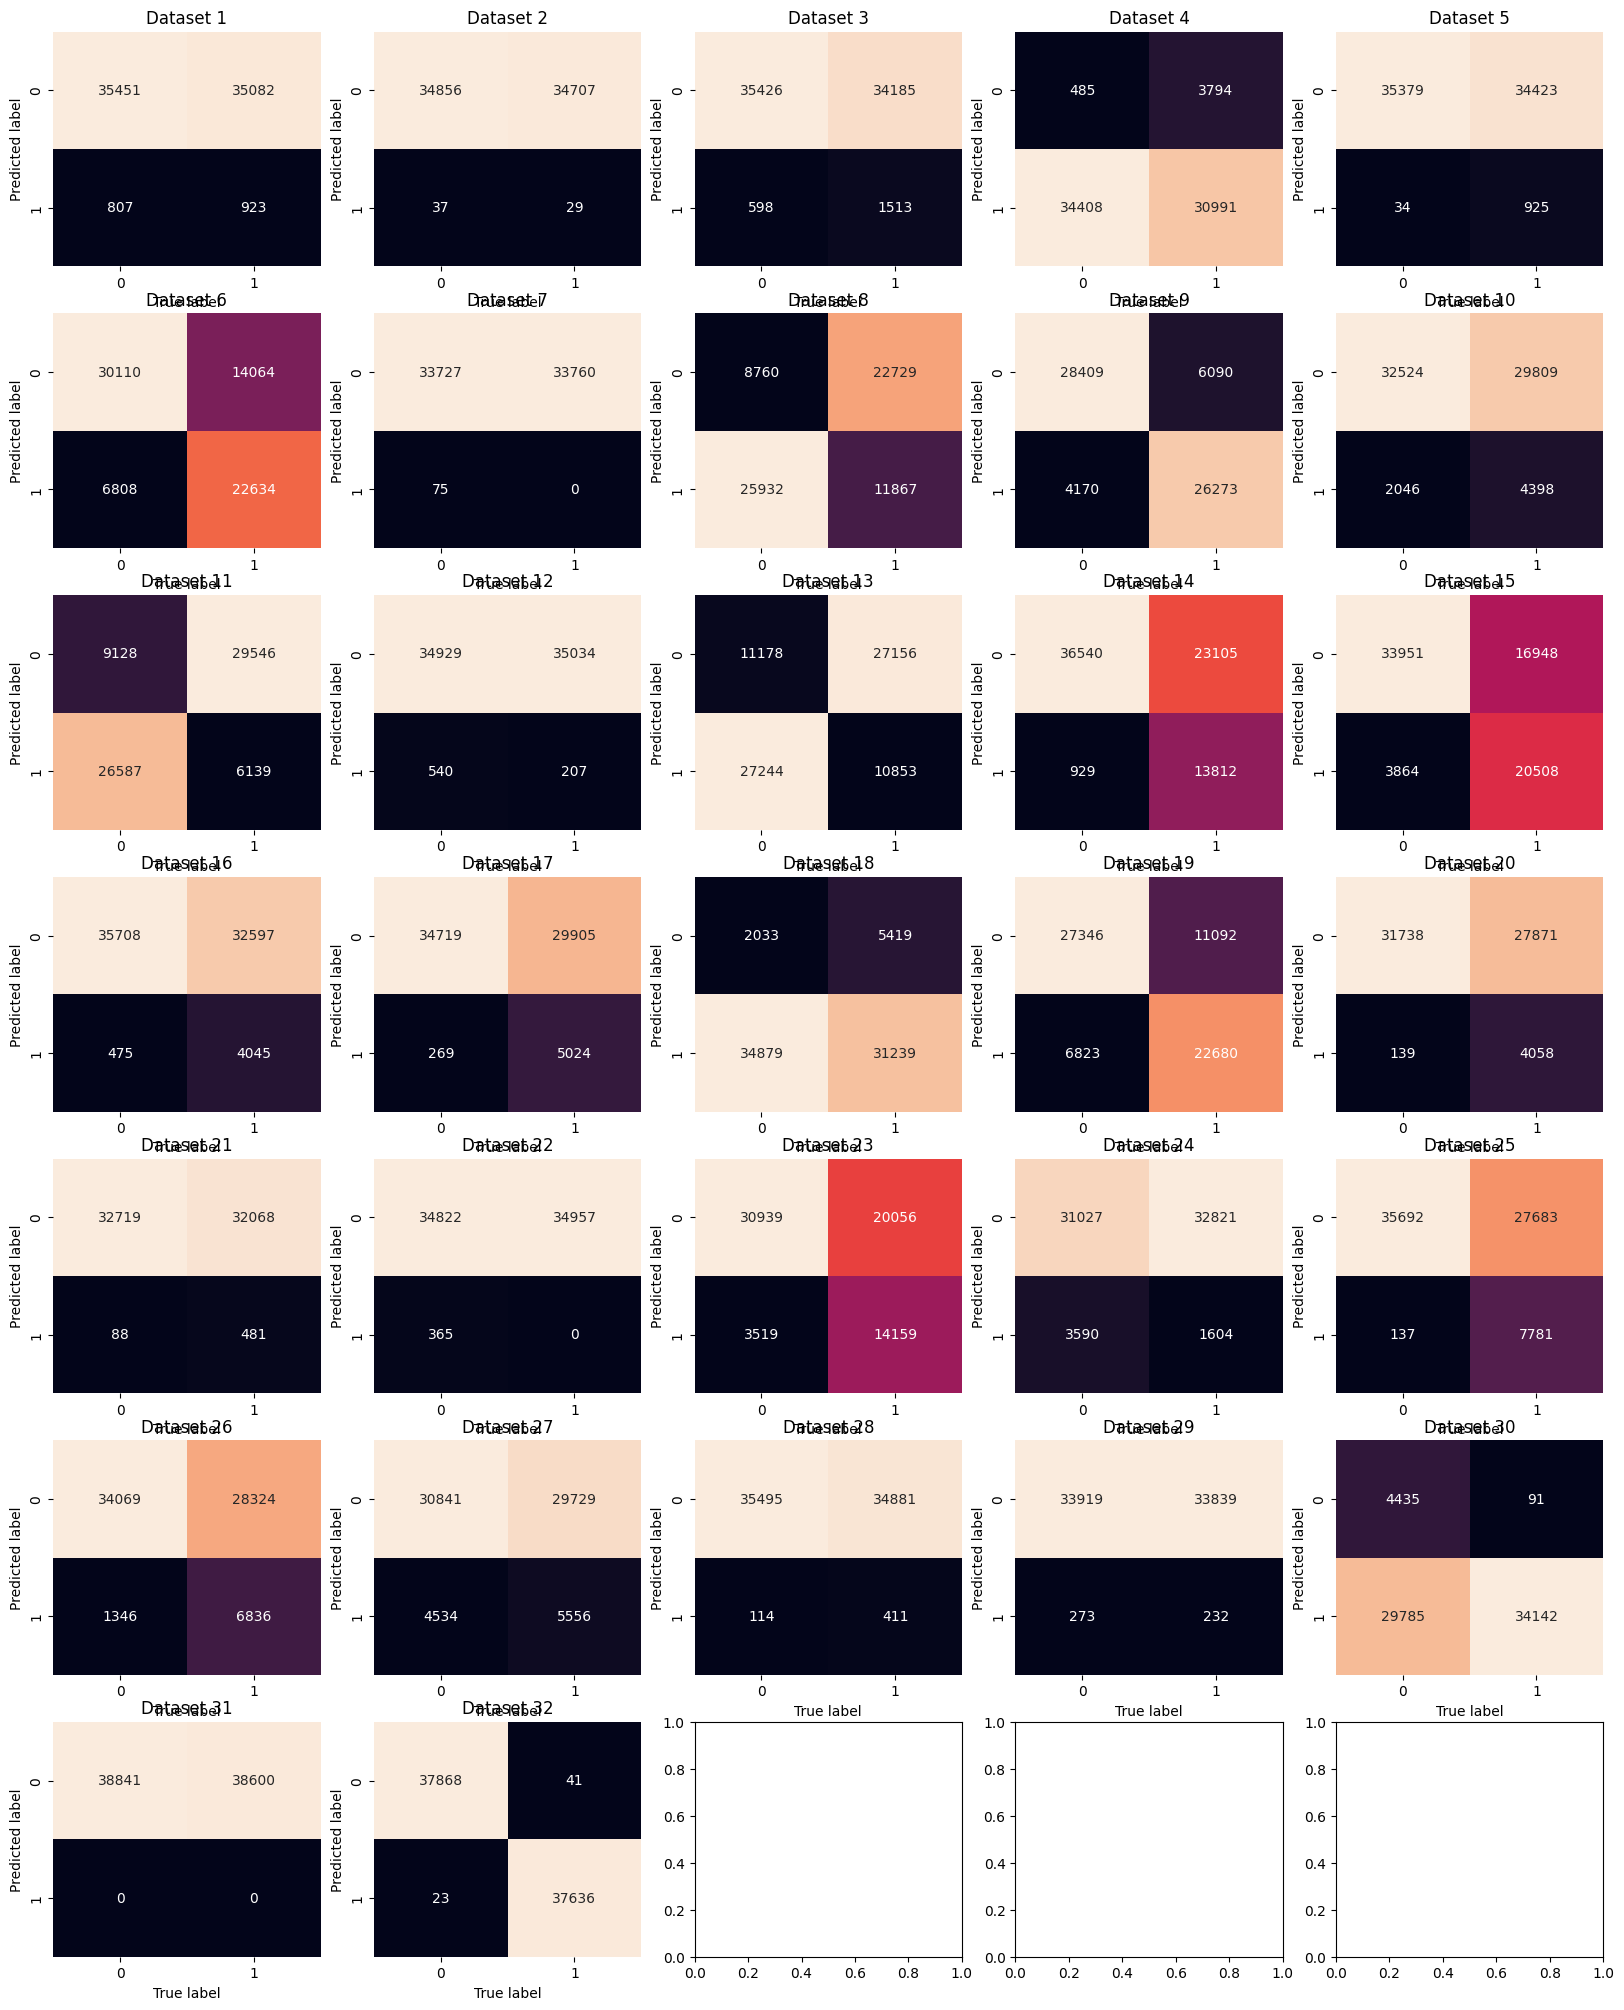

In [ ]:
fig, axs = plt.subplots(nrows=7, ncols=5, figsize=(20, 25))

for i, ax in enumerate(axs.flatten()):
    # Plot the i-th dataset
    sns.heatmap(confusion_matrix(y_preds_data[i], y_test_data_array[i]), annot=True, cbar=False, fmt='g', ax=ax)
    ax.set_xlabel("True label")
    ax.set_ylabel("Predicted label")
    ax.set_title(f"Dataset {i+1}")
    
plt.tight_layout()

In [ ]:
fn_rates = []
for cm in confusion_matrix_data:
    tn, fp, fn, tp = cm.ravel()
    fn_rate = round(fn/(fn+tp+tn+fp)*100, 2)
    fn_rates.append(fn_rate)

avg_fn_rate = np.mean(fn_rates)
print("Average FN Rate:", avg_fn_rate)


Average FN Rate: 35.474374999999995


In [ ]:
fn_rates

[48.55,
 49.85,
 47.66,
 5.45,
 48.65,
 19.1,
 49.97,
 32.8,
 9.38,
 43.34,
 41.38,
 49.55,
 35.53,
 31.06,
 22.52,
 44.76,
 42.77,
 7.37,
 16.33,
 43.68,
 49.07,
 49.84,
 29.21,
 47.54,
 38.83,
 40.13,
 42.07,
 49.2,
 49.57,
 0.13,
 49.84,
 0.05]

In [ ]:
fig, ax = plt.subplots()
ax.hist(fn_rates, bins=10, alpha=0.5, edgecolor='black')
ax.set_xlabel('Rate')
ax.set_ylabel('Frequency')
ax.set_title('False Negatives')
plt.show()

In [ ]:
# Print the classification report for each data frame
for i, df in enumerate(dfs):
    # Load the saved data
    X_train = X_train_data[i]
    X_test = X_test_data[i]
    y_train = y_train_data[i]
    y_test = y_test_data[i]
    y_preds = y_preds_data[i]

    # Print the classification report
    print(f"Classification report for Model {i+1}")
    print(classification_report(y_test, y_preds))
    print("\n")


Classification report for Model 1
              precision    recall  f1-score   support

           0       0.50      0.98      0.66     36258
           1       0.53      0.03      0.05     36005

    accuracy                           0.50     72263
   macro avg       0.52      0.50      0.36     72263
weighted avg       0.52      0.50      0.36     72263



Classification report for Model 2
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     34893
           1       0.44      0.00      0.00     34736

    accuracy                           0.50     69629
   macro avg       0.47      0.50      0.33     69629
weighted avg       0.47      0.50      0.34     69629



Classification report for Model 3
              precision    recall  f1-score   support

           0       0.51      0.98      0.67     36024
           1       0.72      0.04      0.08     35698

    accuracy                           0.52     71722
   macro avg       0.6

In [ ]:
# Evaluate the bestmodel # cross validation

rf_scores = []

for i, _ in enumerate(X_train_data):

    rf_scores = cross_val_score(rf, X_train_data[i], y_train_data[i], cv=10, scoring=make_scorer(f1))
    scores_rf.append(rf_scores)

    rf_scores.mean()

    rf_scores


In [ ]:
rf_scores

array([0.99900813, 0.99920645, 0.99890884, 0.99907438, 0.99930572,
       0.99923954, 0.99910729, 0.99910717, 0.99887588, 0.99887581])

In [ ]:
# Cross-validated accuracy
cv_acc = cross_val_score(rf,
                         X_train_data[0], y_train_data[0],
                         cv=5,
                         scoring="accuracy")
cv_acc = np.mean(cv_acc)
cv_acc

0.9970835399237729

In [ ]:
# Cross-validated precision
cv_precision = cross_val_score(rf,
                         X_train_data[0], y_train_data[0],
                         cv=5,
                         scoring="precision")
cv_precision=np.mean(cv_precision)
cv_precision

0.9954249773733425

In [ ]:
# Cross-validated recall
cv_recall = cross_val_score(rf,
                         X_train_data[0], y_train_data[0],
                         cv=5,
                         scoring="recall")
cv_recall = np.mean(cv_recall)
cv_recall

0.9986242757434841

In [ ]:
# Cross-validated f1-score
cv_f1 = cross_val_score(rf,
                        X_train_data[0], y_train_data[0],
                         cv=5,
                         scoring="f1")
cv_f1 = np.mean(cv_f1)
cv_f1

0.9971012117014835

<Axes: title={'center': 'Cross-validated classification metrics'}>

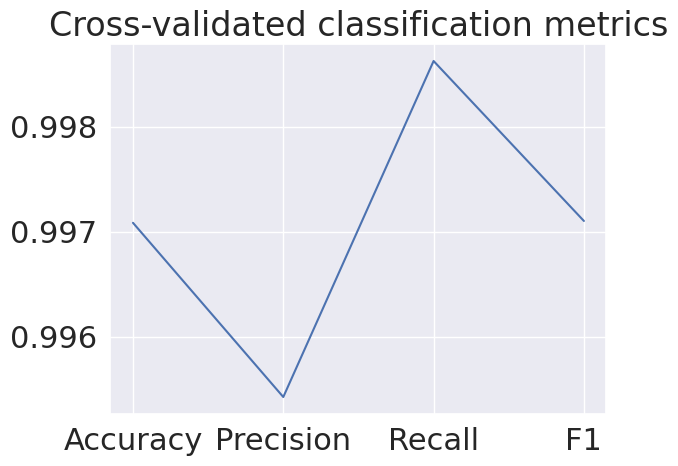

In [ ]:
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1},
                          index=[0])

cv_metrics.T.plot.line(title="Cross-validated classification metrics",legend=False)

In [ ]:
# Fit an instance of Random Forest
clf = RandomForestClassifier(n_estimators=100, max_depth=10)

clf.fit(X_train_data[0], y_train_data[0])

RandomForestClassifier(max_depth=10)

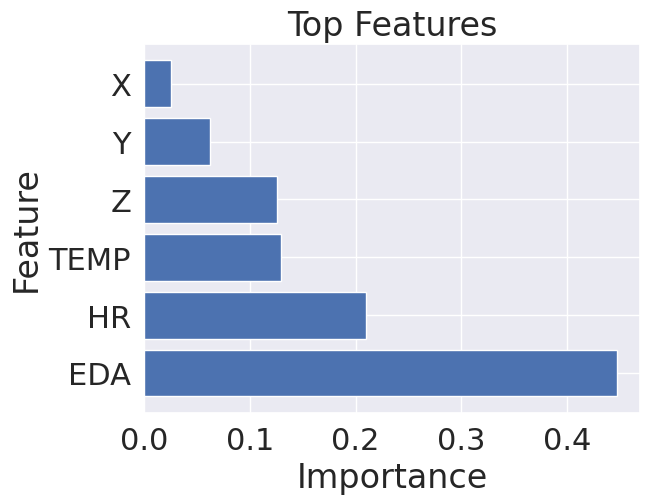

In [ ]:

# extract feature importances
importances = clf.feature_importances_

# create a dictionary of feature names and their importances
feature_dict = dict(zip(X_train_data[0].columns, importances))

# sort the features by importance in descending order
sorted_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)

# extract the top 10 features
top_features = dict(sorted_features[:10])

# plot the top features
plt.barh(range(len(top_features)), list(top_features.values()))
plt.yticks(range(len(top_features)), list(top_features.keys()))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Features')
plt.show()
